# **Explorative Data Analysis - TikTok Data**

## Import Libaries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pytz
import numpy as np
import ipywidgets as widgets
import re
import emoji
import nltk
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from datetime import timedelta
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Load Datasets

In [5]:
df_posts_transcripts = pd.read_csv("../../data/raw_data/posts_transcripts_raw.csv")
df_hashtags_posts = pd.read_csv("../../data/raw_data/hashtags_raw.csv")
df_comments_posts_transcripts = pd.read_csv("../../data/raw_data/comments_posts_transcripts_raw.csv")
df_posts_profiles = pd.read_csv("../../data/raw_data/posts_profiles.csv")
df_music = pd.read_csv("../../data/filtered_data/music.csv")

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_27511/2124390425.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hashtags_posts = pd.read_csv("../../data/raw_data/hashtags_raw.csv")
/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_27511/2124390425.py:3: DtypeWarning: Columns (0,4,7,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments_posts_transcripts = pd.read_csv("../../data/raw_data/comments_posts_transcripts_raw.csv")


In [6]:
df_posts_transcripts.info()
df_hashtags_posts.info()
df_comments_posts_transcripts.info()
df_posts_profiles.info()
df_music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17395 entries, 0 to 17394
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   post_id              17395 non-null  int64 
 1   text                 17206 non-null  object
 2   textLanguage         17393 non-null  object
 3   createTimeISO        17395 non-null  object
 4   isAd                 17395 non-null  bool  
 5   author_nickName      17395 non-null  object
 6   author_signature     16620 non-null  object
 7   author_fans          17395 non-null  int64 
 8   video_duration       17395 non-null  int64 
 9   webVideoUrl          17395 non-null  object
 10  diggCount            17395 non-null  int64 
 11  shareCount           17395 non-null  int64 
 12  playCount            17395 non-null  int64 
 13  collectCount         17395 non-null  int64 
 14  commentCount         17395 non-null  int64 
 15  isSponsored          17395 non-null  bool  
 16  sear

Posts transcripts (posts_transcripts_raw): 7914 rows, 24 columns

Posts from 4 skincare hashtags (hashtags_raw): 78253 rows, 22 columns

Comments and Transcripts from posts (comments_posts_transcripts_raw): 34855 rows, 31 columns

Posts from profiles that Beiersdorf is interested in (posts_profiles): 8192 rows, 17 columns

Music: 9088 rows, 7 columns

--> Most of data is collected from the four skincare related hashtags, therefore further EDA might focus more on this dataset

# Data Preparation

In [7]:
def summarize_df(df, name=""):
    nan_counts = df.isna().sum()
    unique_counts = df.nunique()

    summary = pd.DataFrame({
        'NaNs': nan_counts,
        'Unique Values': unique_counts,
        'Data Type': df.dtypes
    })

    print(f"\n=== Summary for {name} ===")
    print(summary.sort_values(by='NaNs', ascending=False))


# Apply to each dataset
summarize_df(df_posts_transcripts, "Posts Transcripts")
summarize_df(df_hashtags_posts, "Posts from Hashtags")
summarize_df(df_comments_posts_transcripts, "Comments + Posts + Transcripts")
summarize_df(df_posts_profiles, "Posts from Profiles")


=== Summary for Posts Transcripts ===
                      NaNs  Unique Values Data Type
location_address     14303            721    object
transcribed_text      4317          11862    object
detected_language     4012            102    object
bucketUrl             3889          13376    object
video_description     3889          13128    object
author_signature       775           9770    object
text                   189          16928    object
textLanguage             2             76    object
collectCount             0           5206     int64
searchHashtag_views      0            318     int64
searchHashtag_name       0              4    object
isSponsored              0              2      bool
commentCount             0           2648     int64
post_id                  0          17395     int64
playCount                0           7293     int64
diggCount                0           6431     int64
webVideoUrl              0          17395    object
video_duration           

posts_transcripts: Many NaNs for location_address, transcribed_text, detected_language

hashtags_posts: Many NaNs for hashtag_title, country, location_address --> drop hashtag_title

comments_posts_transcripts: Many NaNs for location_address, transcribed_text, detected_language & different comment data

posts_profiles: Many NaNs for location address

In [8]:
# Drop hashtag_title
df_hashtags_posts.drop(columns=['hashtag_title'], inplace=True)

# Convert createTimeISO to datetime and extract country from address
for df in [df_hashtags_posts, df_posts_transcripts, df_comments_posts_transcripts, df_posts_profiles]:
    if "createTimeISO" in df.columns:
        df["createTimeISO"] = pd.to_datetime(df["createTimeISO"], errors='coerce')

    if "location_address" in df.columns and df["location_address"].notna().sum() > 1000:
        df["country"] = df["location_address"].str.extract(r',\s*([^,]+)$')

# Language Distribution

In [9]:
# Top languages in each dataset
def language_distribution(df, name=""):
    if 'textLanguage' in df.columns:
        lang_counts = df['textLanguage'].value_counts(dropna=True)

        if lang_counts.empty:
            print(f"\n{name}: No language data available.")
            return

        lang_dist = lang_counts.reset_index()
        lang_dist.columns = ['Language', 'Count']
        lang_dist['Percentage'] = (lang_dist['Count'] / lang_dist['Count'].sum()) * 100
        lang_dist = lang_dist.sort_values(by='Count', ascending=False).reset_index(drop=True)

        print(f"\n=== Top Languages in {name} ===")
        print(lang_dist.head(5))
    else:
        print(f"\n{name}: No 'textLanguage' column found.")

language_distribution(df_posts_transcripts, "Posts Transcripts")
language_distribution(df_hashtags_posts, "Posts from Hashtags")
language_distribution(df_comments_posts_transcripts, "Comments + Posts + Transcripts")
language_distribution(df_posts_profiles, "Posts from Profiles")



=== Top Languages in Posts Transcripts ===
  Language  Count  Percentage
0       en   8013   46.070258
1       de   5260   30.242051
2       un   1795   10.320244
3       id    479    2.753981
4       es    413    2.374518

=== Top Languages in Posts from Hashtags ===
  Language  Count  Percentage
0       en  75976   47.076610
1       de  50144   31.070464
2       un  16264   10.077577
3       es   3500    2.168687
4       fr   3196    1.980321

=== Top Languages in Comments + Posts + Transcripts ===
  Language   Count  Percentage
0       en  134566   62.910412
1       de   32448   15.169635
2       un   16891    7.896644
3       id    7653    3.577823
4       es    7179    3.356226

=== Top Languages in Posts from Profiles ===
  Language  Count  Percentage
0       de   5638   68.831644
1       en   1640   20.021975
2       un    627    7.654743
3       fr    118    1.440606
4       mr     32    0.390673


Since over 75% of the content is in English or German, we will filter to these two languages for all subsequent analyses.

In [10]:
# Filter for German and English
languages_of_interest = ['en', 'de']

df_posts_transcripts_filtered = df_posts_transcripts[df_posts_transcripts['textLanguage'].isin(languages_of_interest)]
df_hashtags_posts_filtered = df_hashtags_posts[df_hashtags_posts['textLanguage'].isin(languages_of_interest)]
df_comments_filtered = df_comments_posts_transcripts[df_comments_posts_transcripts['textLanguage'].isin(languages_of_interest)]
df_profiles_filtered = df_posts_profiles[df_posts_profiles['textLanguage'].isin(languages_of_interest)]

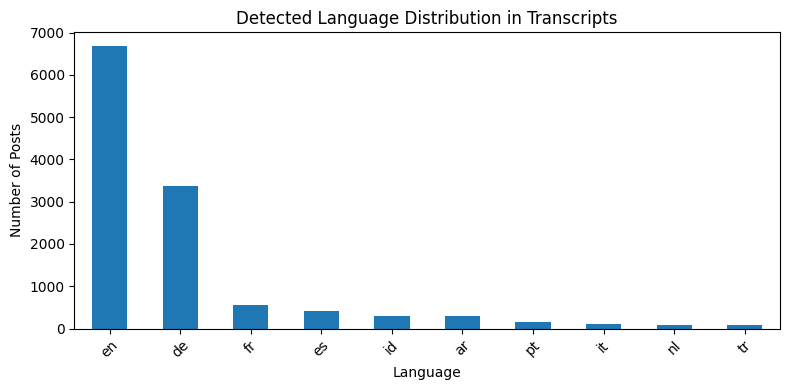

In [11]:
# Detect spoken language from transcripts
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return np.nan

df_posts_transcripts['lang_transcripts'] = df_posts_transcripts['transcribed_text'].apply(detect_language)

# Count detected languages
lang_counts = df_posts_transcripts['lang_transcripts'].value_counts().head(10)

# Plot
plt.figure(figsize=(8, 4))
lang_counts.plot(kind='bar')
plt.title("Detected Language Distribution in Transcripts")
plt.xlabel("Language")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

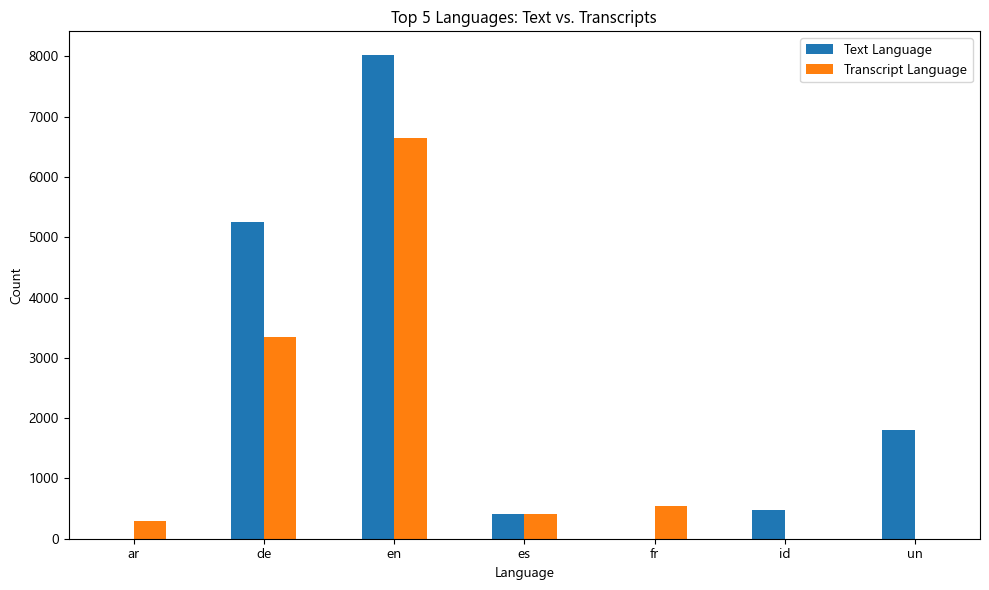

In [ ]:
# Compare top 5 languages in text and transcripts
# Top 5 languages in textLanguage
top5_text = df_posts_transcripts['textLanguage'].value_counts().head(5)

# Top 5 languages in lang_transcripts
top5_transcripts = df_posts_transcripts['lang_transcripts'].value_counts().head(5)

# Combine into a DataFrame for comparison
lang_compare = pd.DataFrame({
    'Text Language': top5_text,
    'Transcript Language': top5_transcripts
}).fillna(0).astype(int)

lang_compare.plot(kind='bar', figsize=(10, 6))
plt.title("Top 5 Languages: Text vs. Transcripts")
plt.ylabel("Count")
plt.xlabel("Language")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

English is the primary language in our datasets, followed by German. There's a broader mix of spoken languages than written ones, implying that creators often caption their videos in English (possibly to reach a wider audience) even when they speak other languages.

**Are Indonesian texts really that frequent or is there any spam?**

In [ ]:
# Filter rows where textLanguage is 'id' (Indonesian)
df_id = df_posts_transcripts[df_posts_transcripts['textLanguage'] == 'id']

# Display basic info
print(f"Number of entries labeled 'id': {len(df_id)}")

# Show the most frequent captions
print("\nMost common captions for 'id' language:")
print(df_id['text'].value_counts().head(10))

# Optional: display some random samples
print("\nRandom sample of 'id' captions:")
print(df_id['text'].sample(5, random_state=42))

# Check average length and duplication rate
avg_len = df_id['text'].str.len().mean()
dup_rate = df_id['text'].duplicated().mean()

print(f"\nAverage length of 'id' captions: {avg_len:.2f} characters")
print(f"Duplicate rate of 'id' captions: {dup_rate:.2%}")

Number of entries labeled 'id': 479

Most common captions for 'id' language:
text
#video anom songot lucu                                                                                                                                                                                               3
Ini dia rahasia nenek 🤫 #skincare #skincareroutine #skincaretips #skincarehacks #fyp #glassskin #glowing #antiaging #facemask                                                                                         1
tekstur cream glow abdalan lembut ringan bund,,wajib co ya🥰 #nenshabeauty #Skincare #Glowing #Bpom #skincaremalang                                                                                                    1
Alhamdulillah hari ini masih diberi kesempatan berbagi kebaikan🤗 Hari ini kebaikan apa yang sudah kalian lakukan?💞 #hnhskincarebydrkamilajaidi #24hours #dikawalsampaiglowup                                          1
Akhirr bulan yawww🥲☺️#skincareroutine #fypage #virall 

The most common caption only appears three times, and the duplicate rate is just 1.25%, which is low. The average length of 146 characters is reasonable. Sample captions are written in proper Indonesian and relate to skincare. 
Looks legitimate and no need to filter them out.

# Content with Advertisements

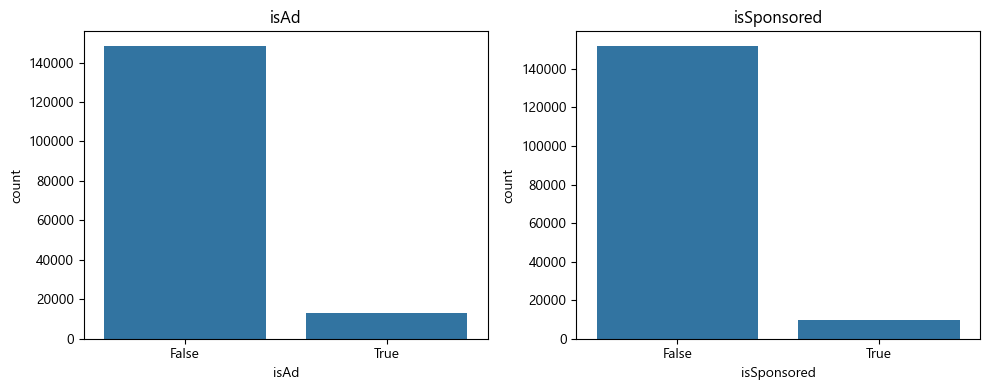

In [ ]:
# Advertisement and Sponsored Posts Analysis for hashtags posts
cols = ["isAd", "isSponsored"]

plt.figure(figsize=(10, 4))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, data=df_hashtags_posts)
    plt.title(col)

plt.tight_layout()
plt.show()

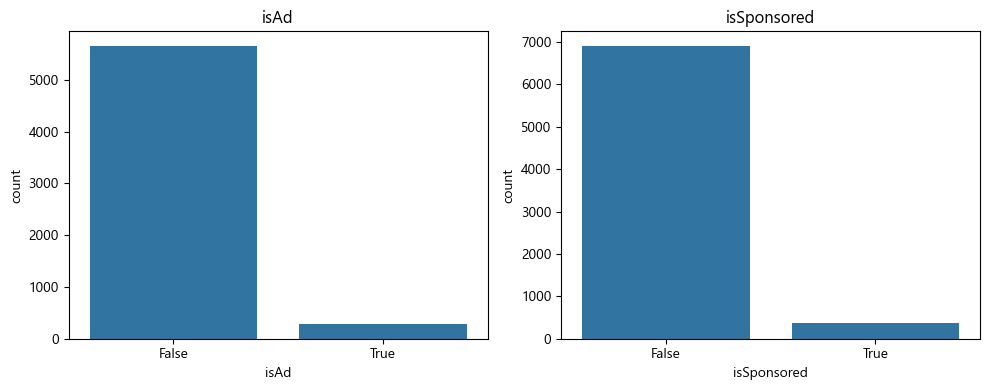

In [ ]:
# Advertisement and Sponsored Posts Analysis for profile posts
cols = ["isAd", "isSponsored"]

plt.figure(figsize=(10, 4))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, data=df_profiles_filtered)
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# Rows where the two flags are not equal
mismatches = df_hashtags_posts[df_hashtags_posts["isAd"] != df_hashtags_posts["isSponsored"]]
print(f"Rows where isAd ≠ isSponsored: {len(mismatches)}")

Rows where isAd ≠ isSponsored: 16305


Nearly all of the data are not ads nor sponsored. 16305 rows is_ad and is_sponsored is different which makes 21%.

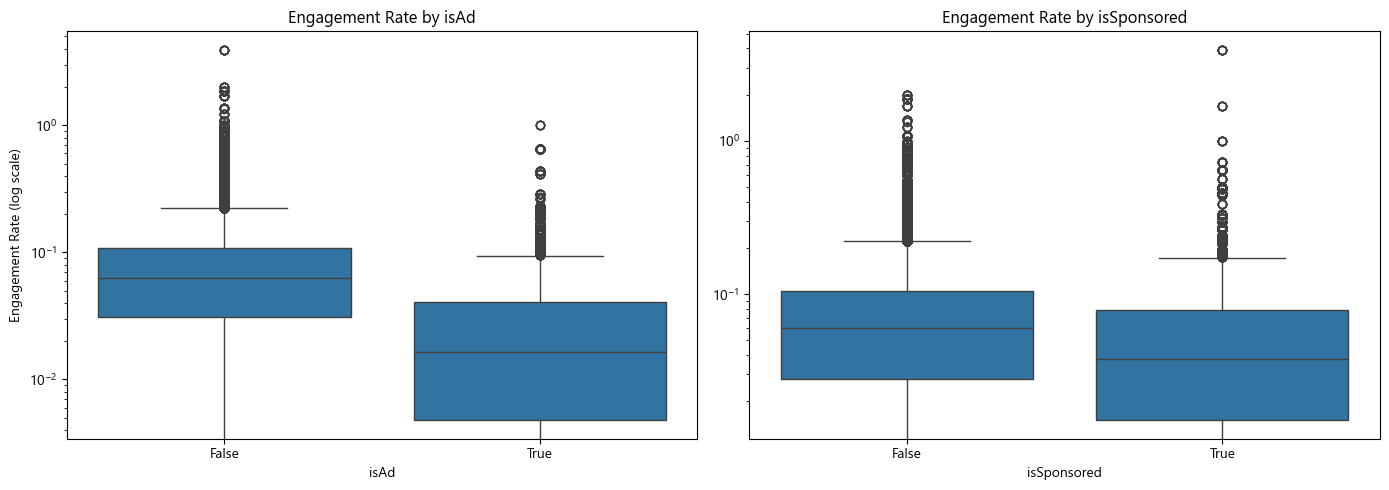

In [ ]:
# Engagement rate per post

# Calculate engagement and engagement rate
df_hashtags_posts["engagement"] = (
    df_hashtags_posts["diggCount"] +
    df_hashtags_posts["commentCount"] +
    df_hashtags_posts["shareCount"] +
    df_hashtags_posts["collectCount"]
)

# Avoid division by zero
df_hashtags_posts = df_hashtags_posts[df_hashtags_posts["playCount"] > 0]

# Engagement rate as a proportion of views
df_hashtags_posts["engagement_rate"] = df_hashtags_posts["engagement"] / df_hashtags_posts["playCount"]

# Plot engagement per post grouped by isAd and isSponsored
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="isAd", y="engagement_rate", data=df_hashtags_posts, ax=axes[0])
axes[0].set_title("Engagement Rate by isAd")
axes[0].set_yscale("log")
axes[0].set_ylabel("Engagement Rate (log scale)")

sns.boxplot(x="isSponsored", y="engagement_rate", data=df_hashtags_posts, ax=axes[1])
axes[1].set_title("Engagement Rate by isSponsored")
axes[1].set_yscale("log")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

Non-ad and non-sponsored posts tend to have higher engagement rates overall. This suggests that ads generate fewer interactions relative to their visibility.

# Success Metrics (Likes, Shares, Comments)

In [ ]:
# Define success metrics
metrics = ["playCount", "diggCount", "commentCount", "collectCount", "shareCount"]

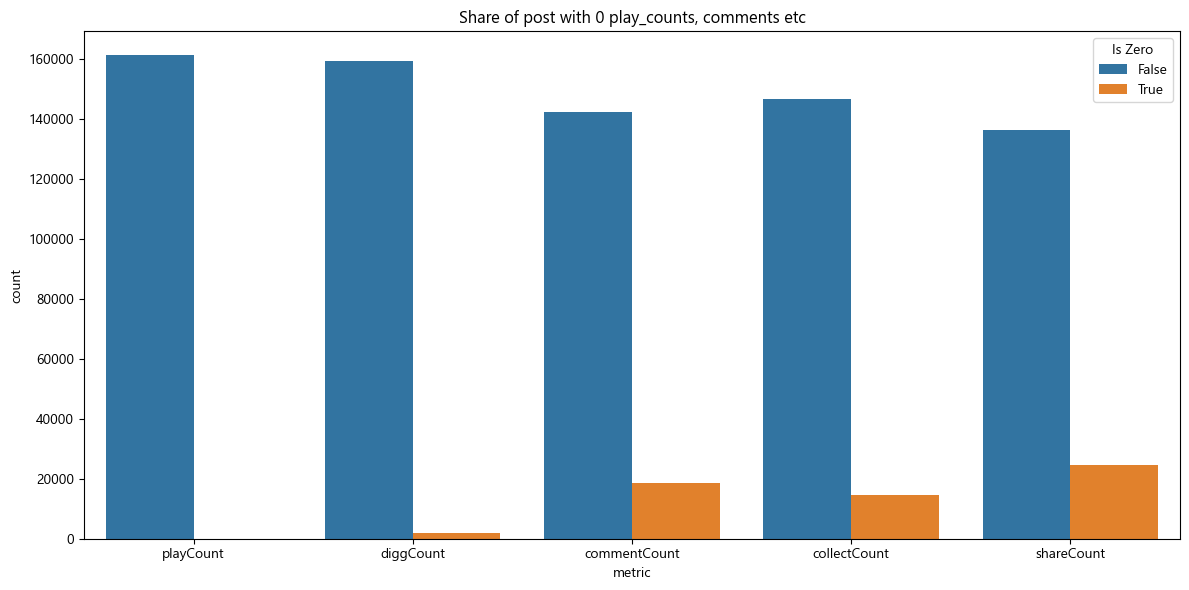

In [ ]:
# Create a melted DataFrame with a new column "is_zero"
metrics_is_zero = df_hashtags_posts[metrics].melt(var_name="metric", value_name="value")
metrics_is_zero["is_zero"] = metrics_is_zero["value"] == 0

plt.figure(figsize=(12, 6))
sns.countplot(data=metrics_is_zero, x="metric", hue="is_zero")
plt.title("Share of post with 0 play_counts, comments etc")
plt.legend(title="Is Zero")
plt.tight_layout()
plt.show()

In [ ]:
# Number of posts with zero playCount
(df_hashtags_posts["playCount"] == 0).sum()

0

We can see that the marjority of posts has user interaction but there are also posts without any comment, share or collect. 

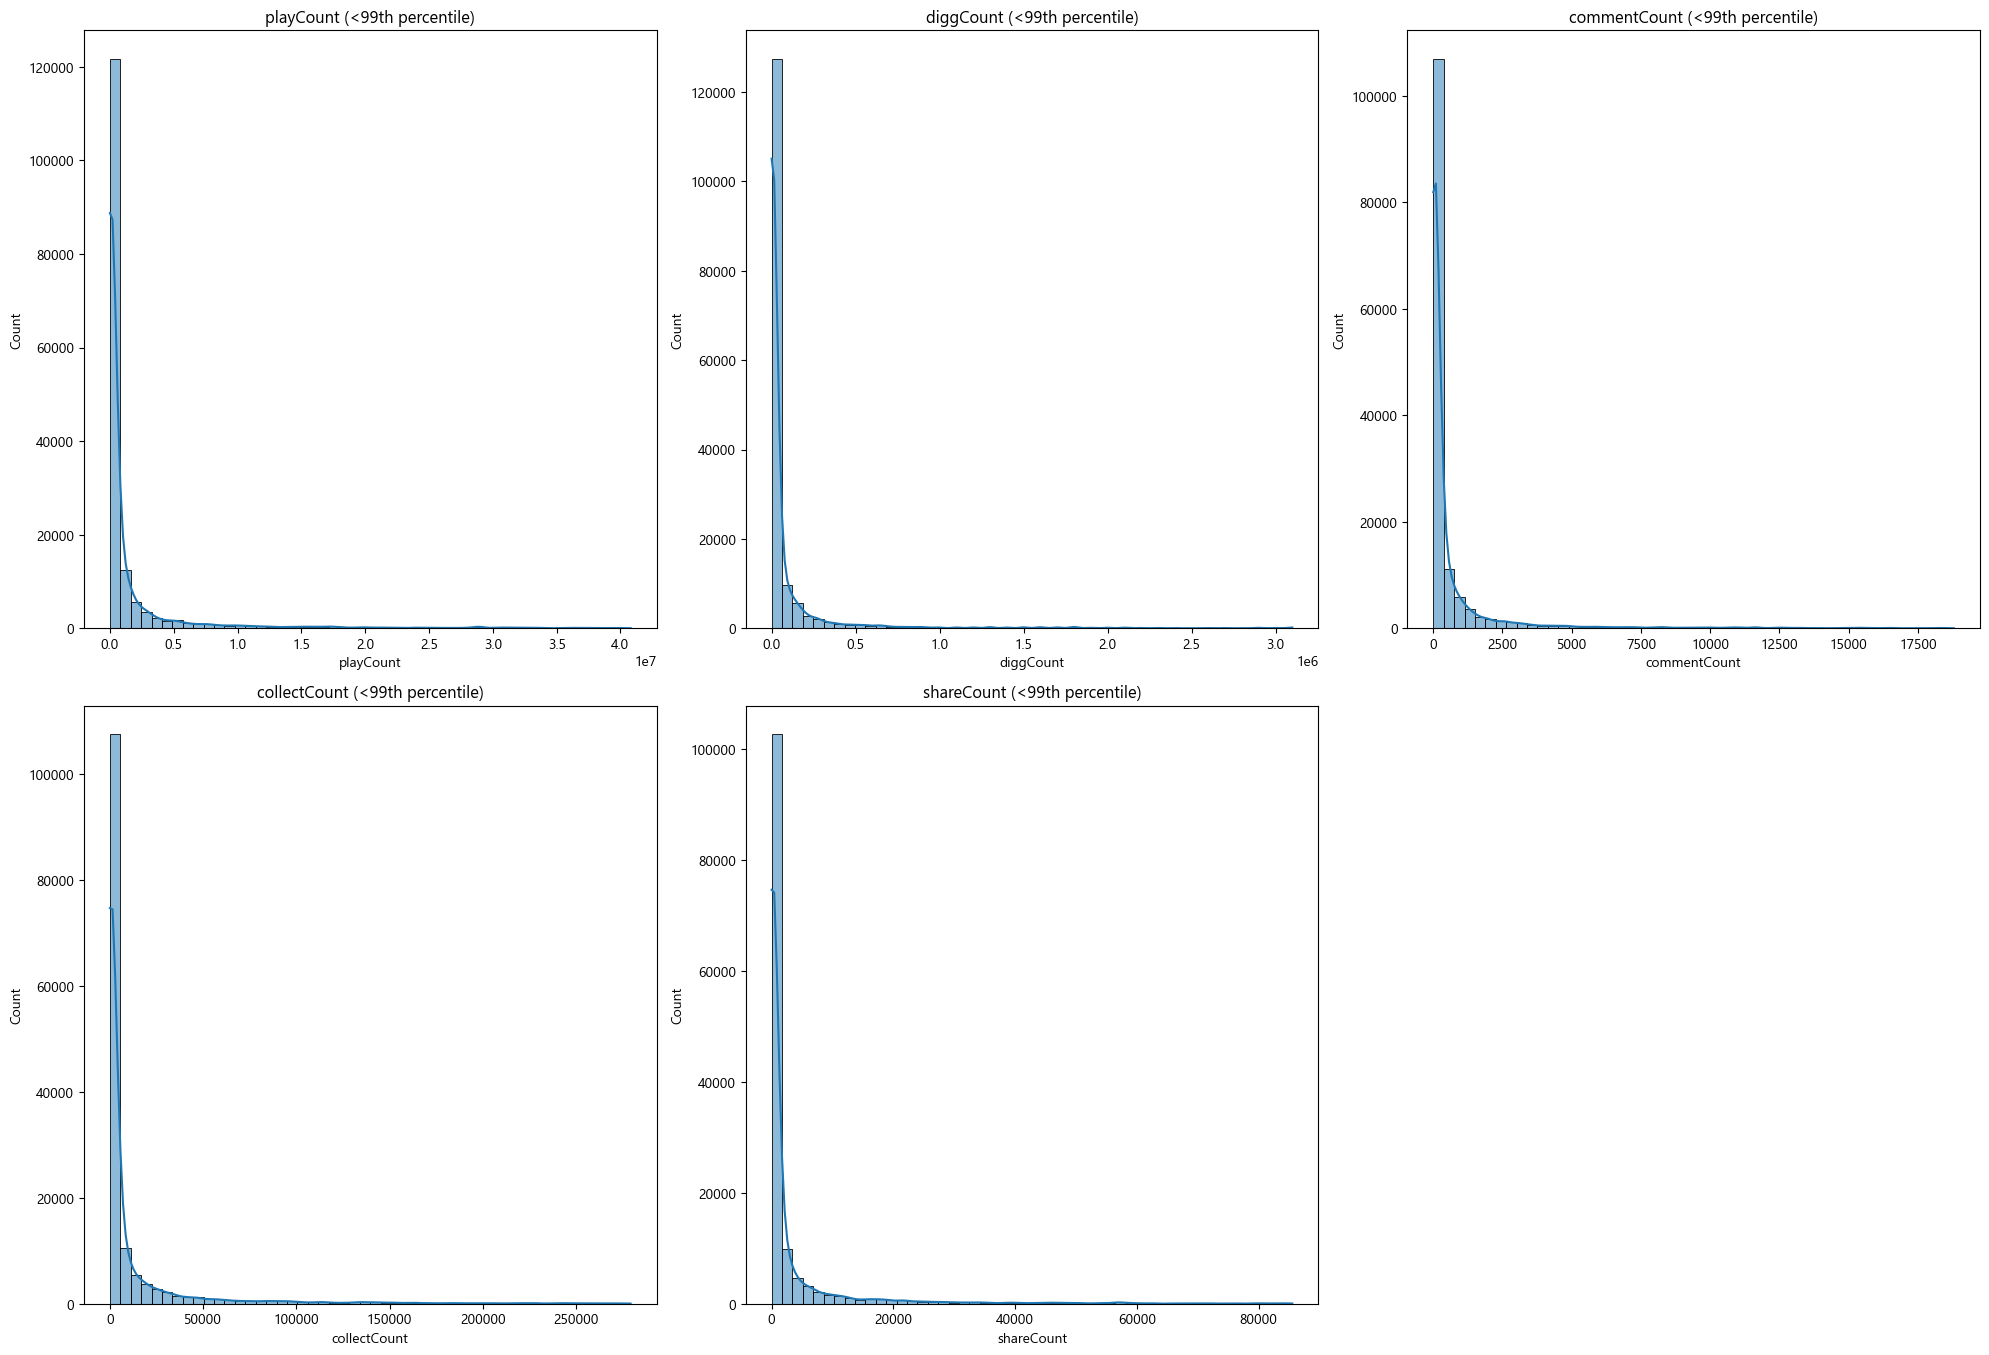

In [ ]:
# Plot distribution of success metrics
plt.figure(figsize=(20, 20))
for i, col in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    q99 = df_hashtags_posts[col].quantile(0.99)
    filtered = df_hashtags_posts[(df_hashtags_posts[col] > 0) & (df_hashtags_posts[col] < q99)]
    sns.histplot(filtered[col], bins=50, kde=True)
    plt.title(f"{col} (<99th percentile)")

plt.tight_layout()
plt.show()

In [ ]:
# Print 99th percentile and max for each metric
for col in metrics:
    q99 = df_hashtags_posts[col].quantile(0.99)
    max_val = df_hashtags_posts[col].max()
    print(f"{col}: 99th perc.:{q99:.0f}, max: {max_val}")

playCount: 99th perc.:41000000, max: 371500000
diggCount: 99th perc.:3200000, max: 18900000
commentCount: 99th perc.:18900, max: 240400
collectCount: 99th perc.:280092, max: 1900000
shareCount: 99th perc.:85900, max: 2800000


The success metrics are highly right skewed meaning a small number of posts are extremely successful.

# Video Duration

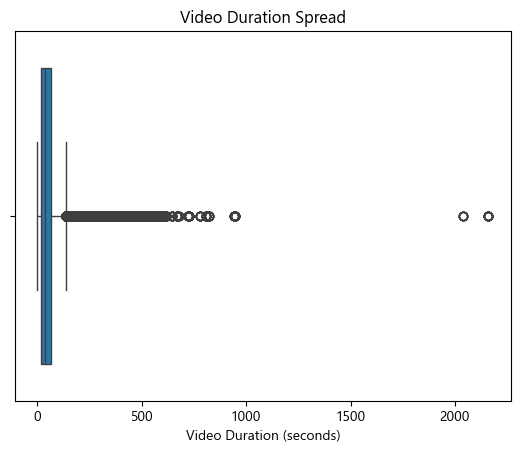

In [ ]:
# Plot video duration 
sns.boxplot(x=df_hashtags_posts["video_duration"])
plt.title("Video Duration Spread")
plt.xlabel("Video Duration (seconds)")
plt.show()

Most videos are under 120 seconds, while there are a few outliers well beyond 1000 seconds.

c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


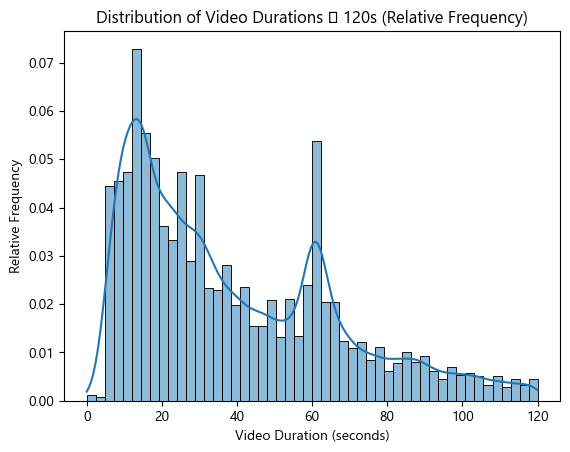

In [ ]:
# Distribution of video durations ≤ 120s (relative frequency)
filtered = df_hashtags_posts[df_hashtags_posts["video_duration"] <= 120]
sns.histplot(filtered["video_duration"], bins=50, kde=True, stat='probability')
plt.title("Distribution of Video Durations ≤ 120s (Relative Frequency)")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Relative Frequency")
plt.show()

Ther is a clear concentration in short durations with notable peaks around 15 and 60 seconds, reflecting common default recording limits on TikTok. 

# Countries

In [ ]:
# Unique names of countries
df_hashtags_posts["country"].unique()

array(['Deutschland', nan, 'Canada', 'Sweden', 'Germany', 'Saudi Arabia',
       'United States', 'Emirates', 'United Kingdom', 'Bangladesh',
       'Mexico', 'Switzerland', 'Indonesia', 'United Arab Emirates',
       'Österreich', 'Italy', 'Philippines', 'France', 'USA', 'Pakistan',
       'المملكة العربية السعودية',
       'Mandarin Oriental Hotel Mandarin Oriental', 'Nigeria',
       'Nederland', 'Australia', 'España', 'Austria', 'Egypt', 'UK',
       'South Africa', 'مصر', 'Brazil', 'Czech Republic',
       'الإمارات العربية المتحدة', 'Spain', 'Japan', 'Turkey', 'Poland',
       'South Korea', 'Damansara Jaya', 'Colombia', 'Türkiye',
       'Netherlands', 'Norway', 'Brasil', 'Slovenia', 'Italia',
       'Republic of Indonesia', 'Seoul', 'Thailand', 'New Zealand',
       'Argentina', 'Algeria', 'Hungary', 'Malaysia', 'Schweiz',
       'Singapore', 'Denmark', 'Greece', 'Seongdong', 'Czechia', 'Kenya',
       'Bangkok 10300 Thailand', 'Seongdong Sangwon 2-gil 7-10'],
      dtype=objec

In [ ]:
# Fix country names
country_fix = {
    "Deutschland": "Germany",
    "Österreich": "Austria",
    "UK": "United Kingdom",
    "USA": "United States",
    "Brasil": "Brazil",
    "Italia": "Italy",
    "مصر": "Egypt",
    "المملكة العربية السعودية": "Saudi Arabia",
    "Turkey": "Türkiye",
    "Bangkok 10300 Thailand": "Thailand",
    "Mandarin Oriental Hotel Mandarin Oriental": None,  # unclear
    "Seongdong Sangwon 2-gil 7-10": None,  # unclear
}

# Apply the fixes
df_hashtags_posts["country_clean"] = df_hashtags_posts["country"].replace(country_fix)

Text(0.5, 1.0, 'Top 10 Countries by Post Volume')

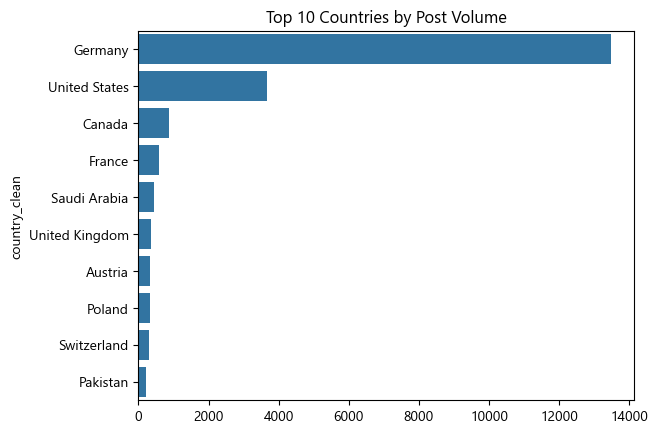

In [ ]:
# Count posts by country
top_countries = df_hashtags_posts['country_clean'].value_counts().head(10)

sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Post Volume")

The vast majority of posts is coming from Germany, followed by the United States.

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\3198386175.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='playCount', y=country_views.index, data=country_views, palette='magma')


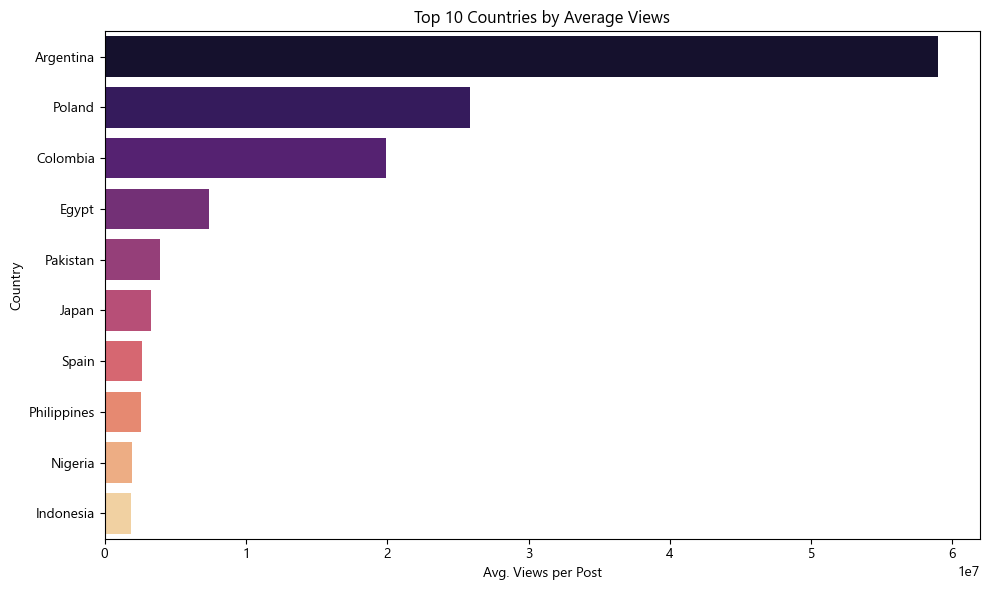

In [ ]:
# Average views per country
df = df_hashtags_posts.copy()
country_views = df.groupby('country_clean').agg({
    'playCount': 'mean',
    'post_id': 'count'
}).sort_values(by='playCount', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='playCount', y=country_views.index, data=country_views, palette='magma')
plt.title("Top 10 Countries by Average Views")
plt.xlabel("Avg. Views per Post")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

Argentina stands out with a significantly higher average view count compared to the rest, followed by Poland and Colombia. The steep drop after the top few countries suggests that content from certain regions may have stronger reach or virality on TikTok, possibly due to localized trends, influencer power, or platform dynamics.

**Deep dive into Argentina**

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\2819216105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_median.values, y=top10_median.index, palette="magma")


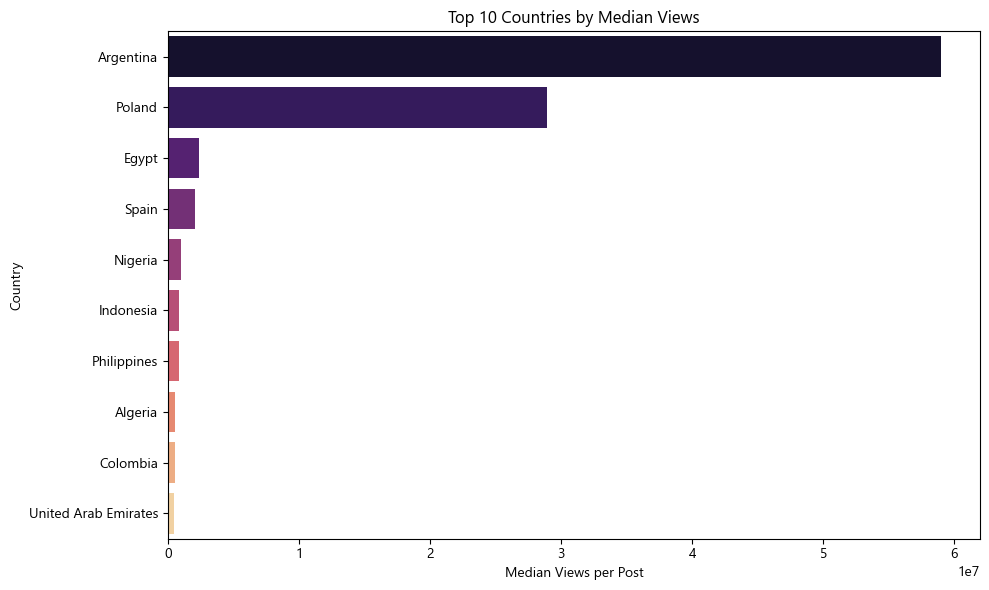

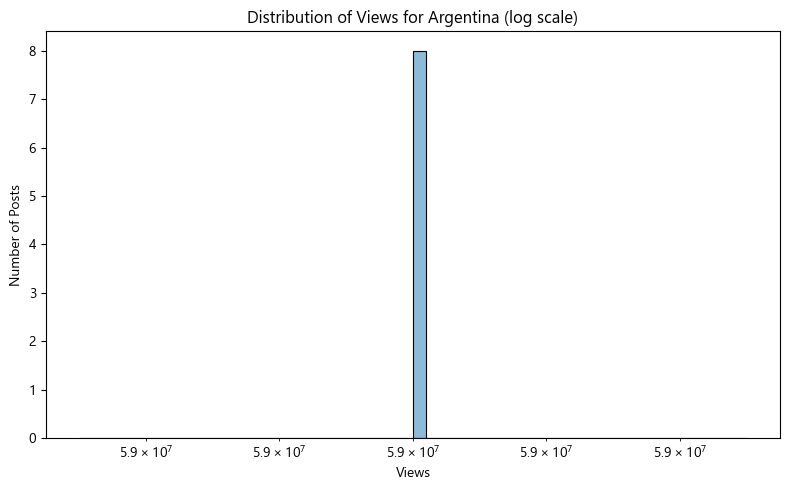

In [ ]:
# Filter posts from Argentina
argentina_posts = df_hashtags_posts[df_hashtags_posts["country_clean"] == "Argentina"]

# Calculate median views for each country
median_views_by_country = df_hashtags_posts.groupby("country_clean")["playCount"].median().sort_values(ascending=False)
top10_median = median_views_by_country.head(10)

# Plot top 10 countries by median views
plt.figure(figsize=(10, 6))
sns.barplot(x=top10_median.values, y=top10_median.index, palette="magma")
plt.title("Top 10 Countries by Median Views")
plt.xlabel("Median Views per Post")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Plot distribution of views for Argentina
plt.figure(figsize=(8, 5))
sns.histplot(argentina_posts["playCount"], bins=50, kde=True)
plt.xscale("log")
plt.title("Distribution of Views for Argentina (log scale)")
plt.xlabel("Views")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

Argentina ranks at the top for both average and median views per post, but this is due to a small number of posts with identical, extremely high view counts (~59M). This indicates likely viral duplication or reuse of the same post, rather than widespread high engagement from the country overall.

# Time Trends for Posts

In [ ]:
timezone_map = {
    "Germany": "Europe/Berlin",
    "France": "Europe/Paris",
    "Türkiye": "Europe/Istanbul",
    "Saudi Arabia": "Asia/Riyadh",
    "United States": "America/New_York",  # default — or map by state later
    "Canada": "America/Toronto",
    "Switzerland": "Europe/Zurich",
    "South Korea": "Asia/Seoul",
    "Pakistan": "Asia/Karachi",
    "Indonesia": "Asia/Jakarta",
    "Greece": "Europe/Athens",
    "Philippines": "Asia/Manila",
    "Sweden": "Europe/Stockholm",
    "Kenya": "Africa/Nairobi",
    "Egypt": "Africa/Cairo",
    "South Africa": "Africa/Johannesburg",
    "Austria": "Europe/Vienna",
    "United Kingdom": "Europe/London",
    "Nigeria": "Africa/Lagos",
    "Poland": "Europe/Warsaw",
    "Bangladesh": "Asia/Dhaka",
    "Australia": "Australia/Sydney",
    "Brazil": "America/Sao_Paulo",
    "Colombia": "America/Bogota",
    "United Arab Emirates": "Asia/Dubai",
    "Italy": "Europe/Rome",
    "Czechia": "Europe/Prague",
    "Thailand": "Asia/Bangkok",
    "Mexico": "America/Mexico_City",
    "Nederland": "Europe/Amsterdam",
    "Japan": "Asia/Tokyo",
    "Algeria": "Africa/Algiers"
}


In [ ]:
# Convert createTimeISO to UTC datetime
df_hashtags_posts['utc_time'] = pd.to_datetime(df_hashtags_posts['createTimeISO'], utc=True)

# Calculate local time for valid countries
df_hashtags_posts['local_time'] = [
    utc.astimezone(pytz.timezone(timezone_map[country])) if pd.notna(country) and country in timezone_map else pd.NaT
    for utc, country in zip(df_hashtags_posts['utc_time'], df_hashtags_posts['country'])
]

# Extract hours
df_hashtags_posts['hour'] = df_hashtags_posts['local_time'].astype(str).str.extract(r'(\d{2}):')[0].astype('Int64')


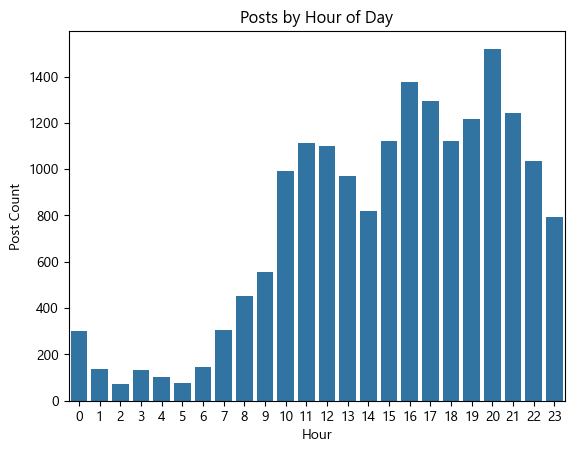

In [ ]:
# Posts by hour of the day
sns.countplot(x="hour", data=df_hashtags_posts)
plt.title("Posts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Post Count")
plt.show()

People post most often in the evening between 20:00 to 22:00. During the night, 1am and later, there are the least posts.

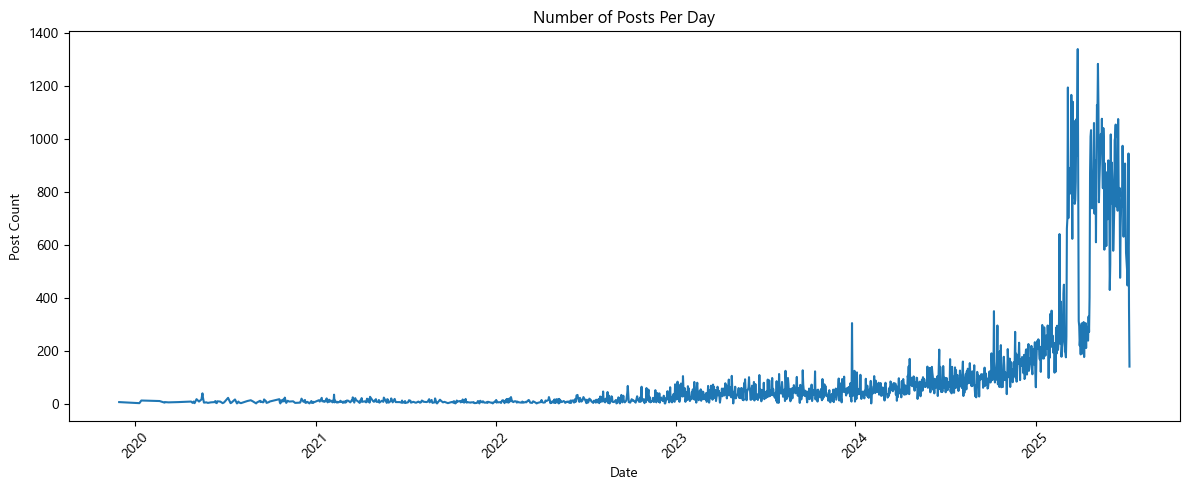

In [ ]:
# Number of posts per day (all data)
posts_per_day = df_hashtags_posts["createTimeISO"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
posts_per_day.plot()
plt.title("Number of Posts Per Day")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There was a significant increase in collected data starting with 2025.

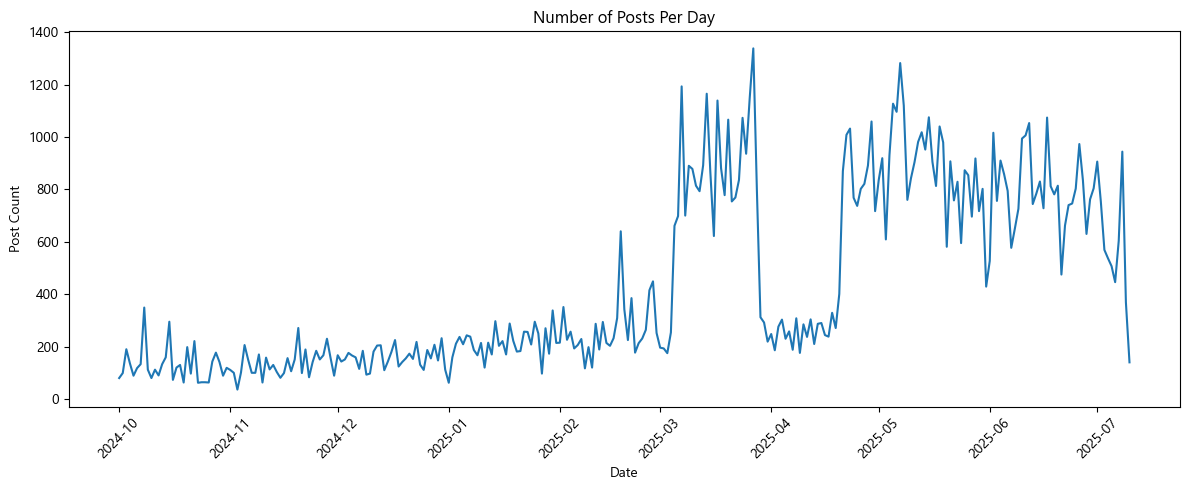

In [ ]:
# Number of posts per day (from October 2024)
mask = df_hashtags_posts["createTimeISO"].dt.date >= pd.to_datetime("2024-10-01").date()
posts_per_day = df_hashtags_posts.loc[mask, "createTimeISO"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
posts_per_day.plot()
plt.title("Number of Posts Per Day")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

More precisely there was an increase in collected data starting with March 2025 but a decrease for half of April. In future analysis we will focus only on posts from 2025 to keep the data consistent and ensure it reflects the most relevant trends and behaviors. We will also make sure to use normalized statistics to ensure the rise and fall down of the number of posts does not distort the results.

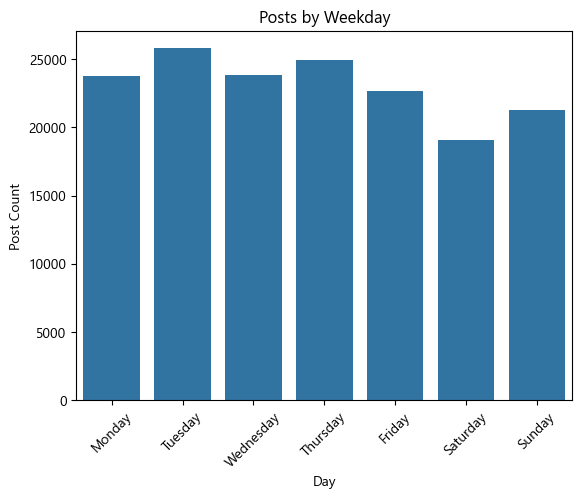

In [ ]:
# Posts by weekday
df_hashtags_posts["weekday"] = df_hashtags_posts["createTimeISO"].dt.day_name()

sns.countplot(x="weekday", data=df_hashtags_posts,
              order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Posts by Weekday")
plt.xlabel("Day")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.show()


Posts are most frequently published on weekdays, especially Tuesday and Thursday. Posting activity dips over the weekend.

# Influencer Analysis

In [ ]:
# Top influencer by number of followers
top_creators = df_profiles_filtered.groupby('author_nickName').agg({
    'post_id': 'count',
    'author_fans': 'first',
    'playCount': 'mean',
    'diggCount': 'mean',
    'commentCount': 'mean'
}).sort_values(by='author_fans', ascending=False).head(20)

top_creators.head()

,post_id,author_fans,playCount,diggCount,commentCount
author_nickName,,,,,
YZ,25,56700000,3.148784e+06,152688.120000,1896.800000
Noemi Nikita,97,13300000,1.322506e+06,67719.639175,1979.865979
Jule,17,6900000,1.022118e+06,99388.235294,460.470588
Paula Wolf 🐺,119,6700000,6.393223e+05,49689.436975,538.411765
Cedrik Lorenzen,22,5900000,3.340277e+06,223099.000000,3309.863636


In [ ]:
# Get follower count per author
followers_per_author = df_profiles_filtered.groupby('author_nickName')['author_fans'].first()

# Calculate average and median
avg_followers = followers_per_author.mean()
median_followers = followers_per_author.median()

print(f"Average number of followers per author: {avg_followers:.2f}")
print(f"Median number of followers per author: {median_followers:.2f}")

Average number of followers per author: 1375999.81
Median number of followers per author: 364200.00


The large gap between the average and median indicates that a few very large influencers (with millions of followers) are pulling the average up, while most authors have significantly fewer followers.

In [ ]:
# Top influencers by number of views
top_views = df_hashtags_posts.groupby('author_nickName').agg({
    'playCount': 'mean',
    'diggCount': 'mean',
    'commentCount': 'mean',
    'collectCount': 'mean',
    'shareCount': 'mean'
}).sort_values(by='playCount', ascending=False).head(20)
top_views.head()

,playCount,diggCount,commentCount,collectCount,shareCount
author_nickName,,,,,
Tanisha Ahuja,257100000.0,1700000.0,5974.0,243300.0,63000.0
Jocelyn 🩰,204500000.0,1700000.0,6370.0,103200.0,31600.0
STEFFANY,189900000.0,2900000.0,14400.0,586600.0,238700.0
Glenda,158300000.0,12500000.0,83300.0,1100000.0,1200000.0
Briel Adams-Wheatley,141600000.0,1100000.0,0.0,79000.0,920500.0


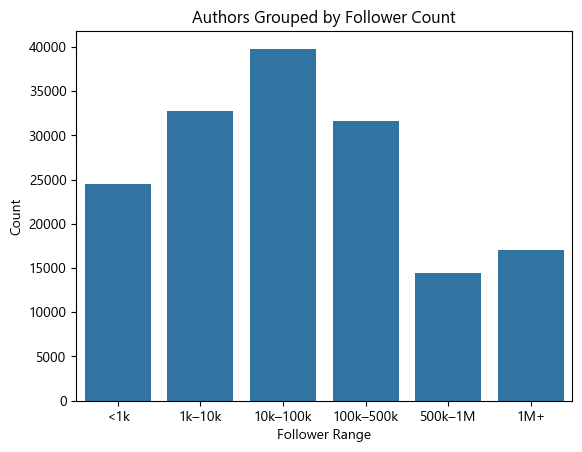

In [ ]:
# Group authors by follower count
bins = [0, 1_000, 10_000, 100_000,500_000, 1_000_000, np.inf]
labels = ['<1k', '1k–10k', '10k–100k', '100k–500k', '500k–1M', '1M+']
df_hashtags_posts['fans_bin'] = pd.cut(df_hashtags_posts['author_fans'], bins=bins, labels=labels)

sns.countplot(x='fans_bin', data=df_hashtags_posts)
plt.title("Authors Grouped by Follower Count")
plt.xlabel("Follower Range")
plt.ylabel("Count")
plt.show()

Most of the creators have a number of followers between 10-100k.

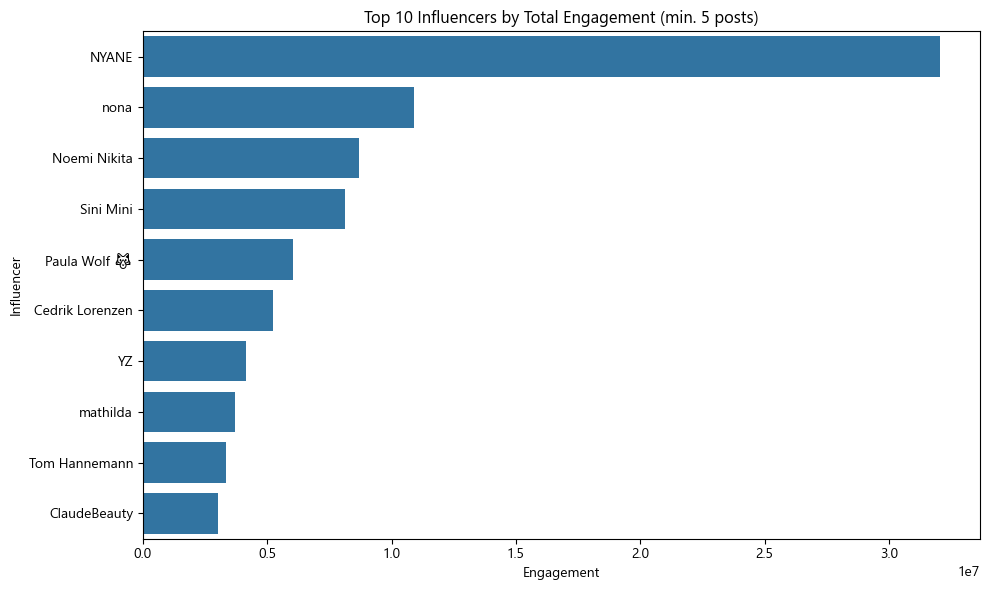

In [ ]:
# Top 10 influencers by total engagement
df = df_profiles_filtered.copy()

# Calculate engagement
df['engagement'] = df['diggCount'] + df['commentCount'] + df['shareCount']

# Group by influencer
grouped = df.groupby('author_nickName').agg({
    'engagement': 'sum',
    'playCount': 'sum',
    'author_fans': 'first',
    'post_id': 'count'
}).rename(columns={'post_id': 'num_posts'}).reset_index()

# Only influencers with at least 5 posts
grouped = grouped[grouped['num_posts'] >= 5]

# Sort and plot top 10
top_influencers = grouped.sort_values(by='engagement', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='engagement', y='author_nickName', data=top_influencers)
plt.title("Top 10 Influencers by Total Engagement (min. 5 posts)")
plt.xlabel("Engagement")
plt.ylabel("Influencer")
plt.tight_layout()
plt.show()


This chart highlights creators who generated the highest total number of interactions (likes, comments, shares, saves), indicating their broad reach and content virality. These influencers tend to have larger audiences or content that repeatedly gains wide traction.

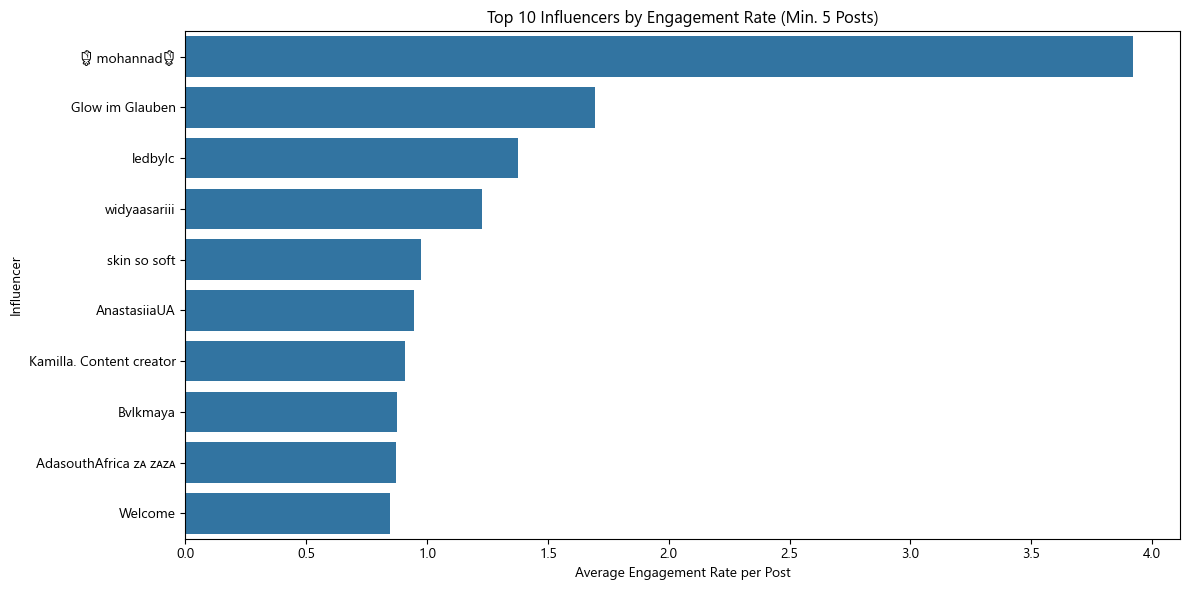

In [ ]:
# Top 10 influencers by average engagement rate
# Aggregate metrics and count number of posts per influencer
top_engagement = df_hashtags_posts.groupby('author_nickName').agg({
    'playCount': 'mean',
    'diggCount': 'mean',
    'commentCount': 'mean',
    'collectCount': 'mean',
    'shareCount': 'mean',
    'post_id': 'count'  # assuming 'post_id' exists and is unique per post
}).rename(columns={'post_id': 'num_posts'})

# Filter out influencers with fewer than 5 posts and nonzero views
top_engagement = top_engagement[(top_engagement["num_posts"] >= 5) & (top_engagement["playCount"] > 0)]

# Calculate engagement rate
top_engagement["engagementRate"] = (
    top_engagement["diggCount"] +
    top_engagement["commentCount"] +
    top_engagement["collectCount"] +
    top_engagement["shareCount"]
) / top_engagement["playCount"]

# Get top 20 by engagement rate
top20_engagement = top_engagement.sort_values(by="engagementRate", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top20_engagement["engagementRate"],
    y=top20_engagement.index,
)
plt.title("Top 10 Influencers by Engagement Rate (Min. 5 Posts)")
plt.xlabel("Average Engagement Rate per Post")
plt.ylabel("Influencer")
plt.tight_layout()
plt.show()


This plot reveals creators whose audiences are most actively engaging relative to views, pointing to strong community connection or highly compelling content. Unlike total engagement, it surfaces high-performing micro-influencers who drive deeper viewer interaction.

# Hashtags Exploration

**Search Hashtags**

These are the four hashtags that were used to collect skincare related data

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\3956678581.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=search_hashtag_counts.values, y=search_hashtag_counts.index, palette="pastel")


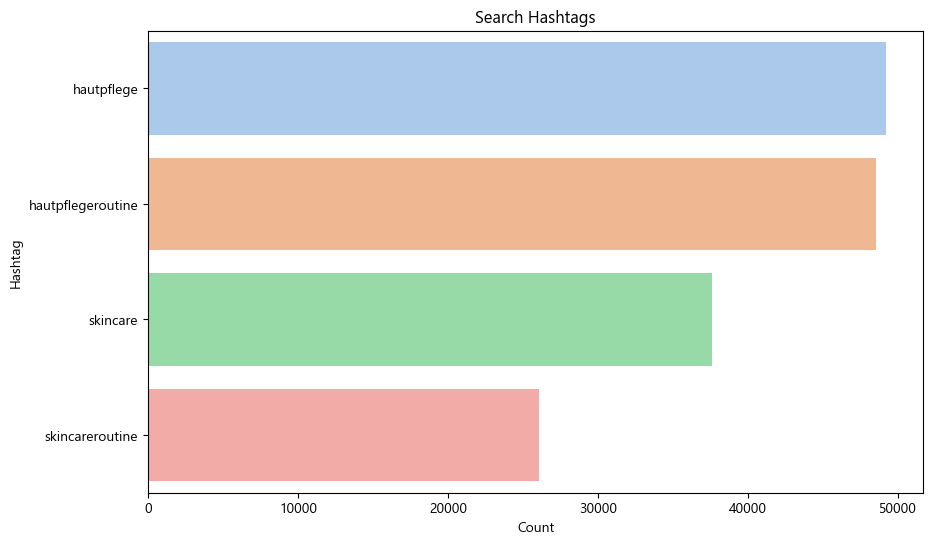

In [ ]:
# Number of posts by search hashtags
unique_searchhashtags = df_hashtags_posts['searchHashtag_name'].unique() 

search_hashtag_counts = df_hashtags_posts.searchHashtag_name.value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=search_hashtag_counts.values, y=search_hashtag_counts.index, palette="pastel")
plt.title("Search Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.show()

More data come from the two German Hashtags.

**Most common and engaging hashtags**

Sidenote: Looking in Bigquery found out that search_hashtag is actually not always part of the hashtags

In [ ]:
data_hashtags = pd.read_csv("../data/filtered_data/hashtags_posts.csv")

In [ ]:
(data_hashtags['searchHashtag_name'] == data_hashtags['hashtag_name']).sum()

3664

In [ ]:
unique_hashtags = data_hashtags['hashtag_name'].unique() 
len(unique_hashtags)

15731

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\2050816742.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hashtag_counts.values, y=hashtag_counts.index, palette="pastel")


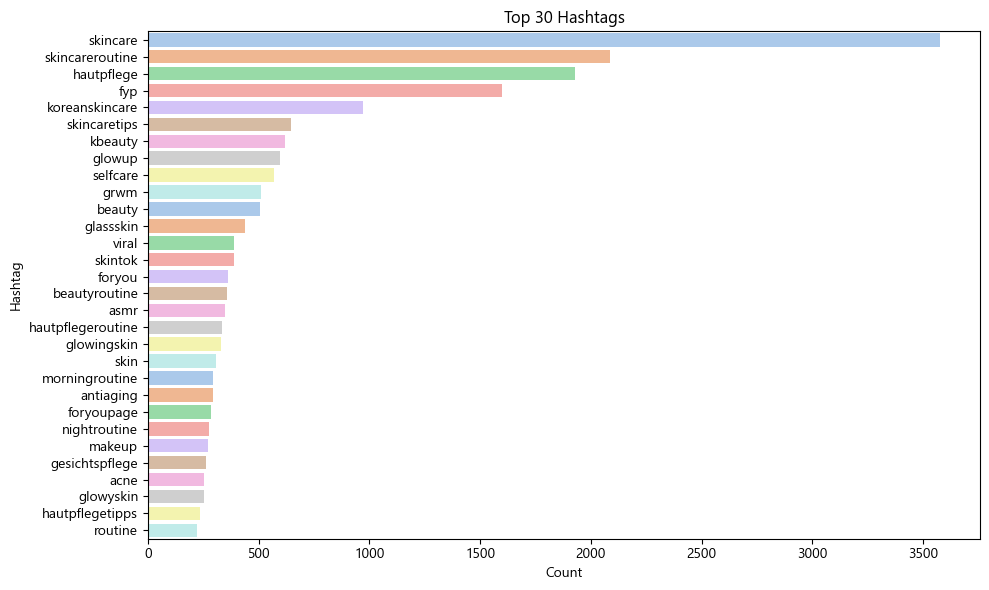

In [ ]:
# Count top hashtags
hashtag_counts = data_hashtags.hashtag_name.value_counts().head(30)  # top 30

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=hashtag_counts.values, y=hashtag_counts.index, palette="pastel")
plt.title("Top 30 Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.tight_layout()
plt.show()

The four search hashtags are at the top of the ranking. Followed by "fyp" and "koreanskincare".

In [ ]:
# Count posts per hashtag
hashtag_post_counts = (
    data_hashtags.groupby('hashtag_name')['post_id']
    .nunique()
    .sort_values(ascending=False)
)

quantiles = hashtag_post_counts.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])
print("Quantils of number of posts per Hashtag:")
print(quantiles)

Quantils of number of posts per Hashtag:
0.250     1.0
0.500     1.0
0.750     2.0
0.900     6.0
0.950    10.0
0.975    20.0
0.990    50.0
Name: post_id, dtype: float64


90% of the hashtags have 6 or less posts and the median (50 % quantile) is at only 1 post, showing that most of the hashtags are used rarely.

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


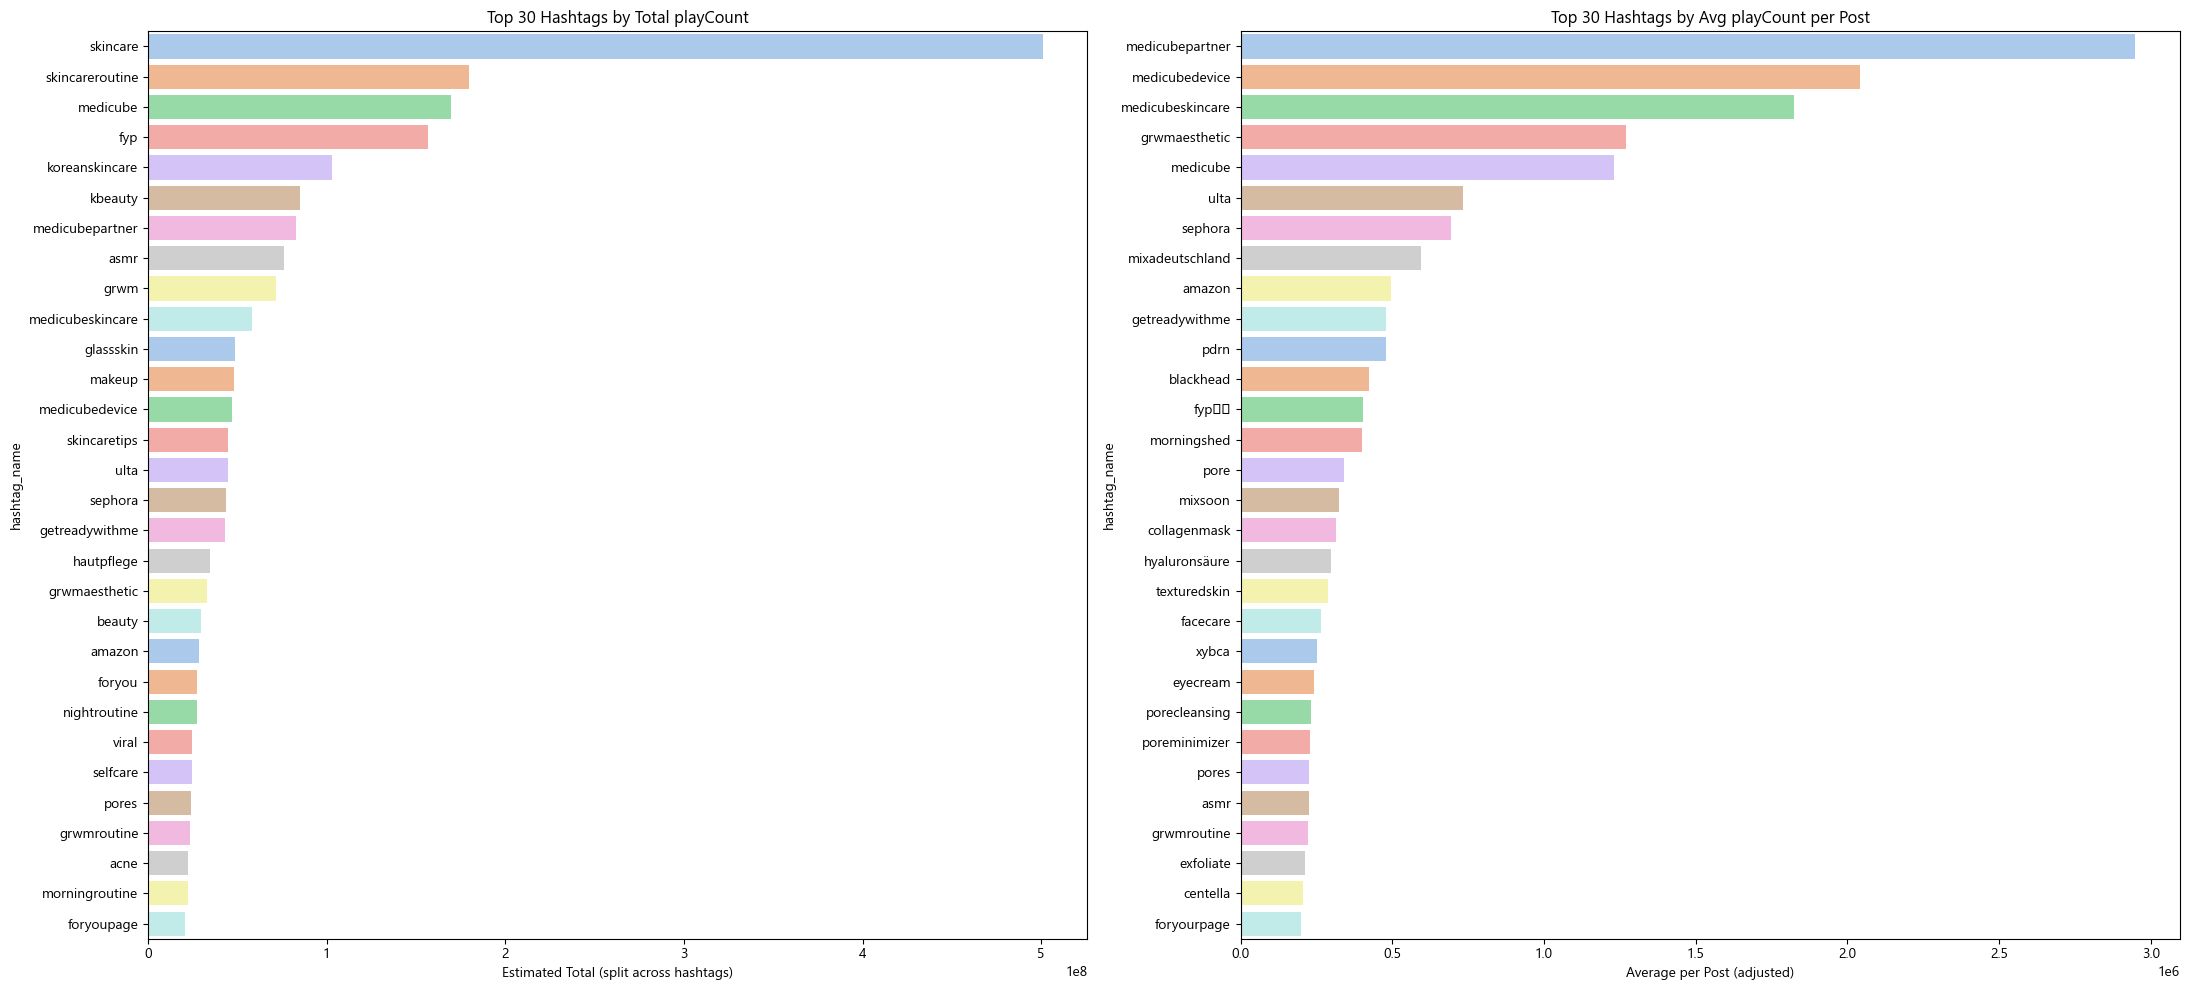

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


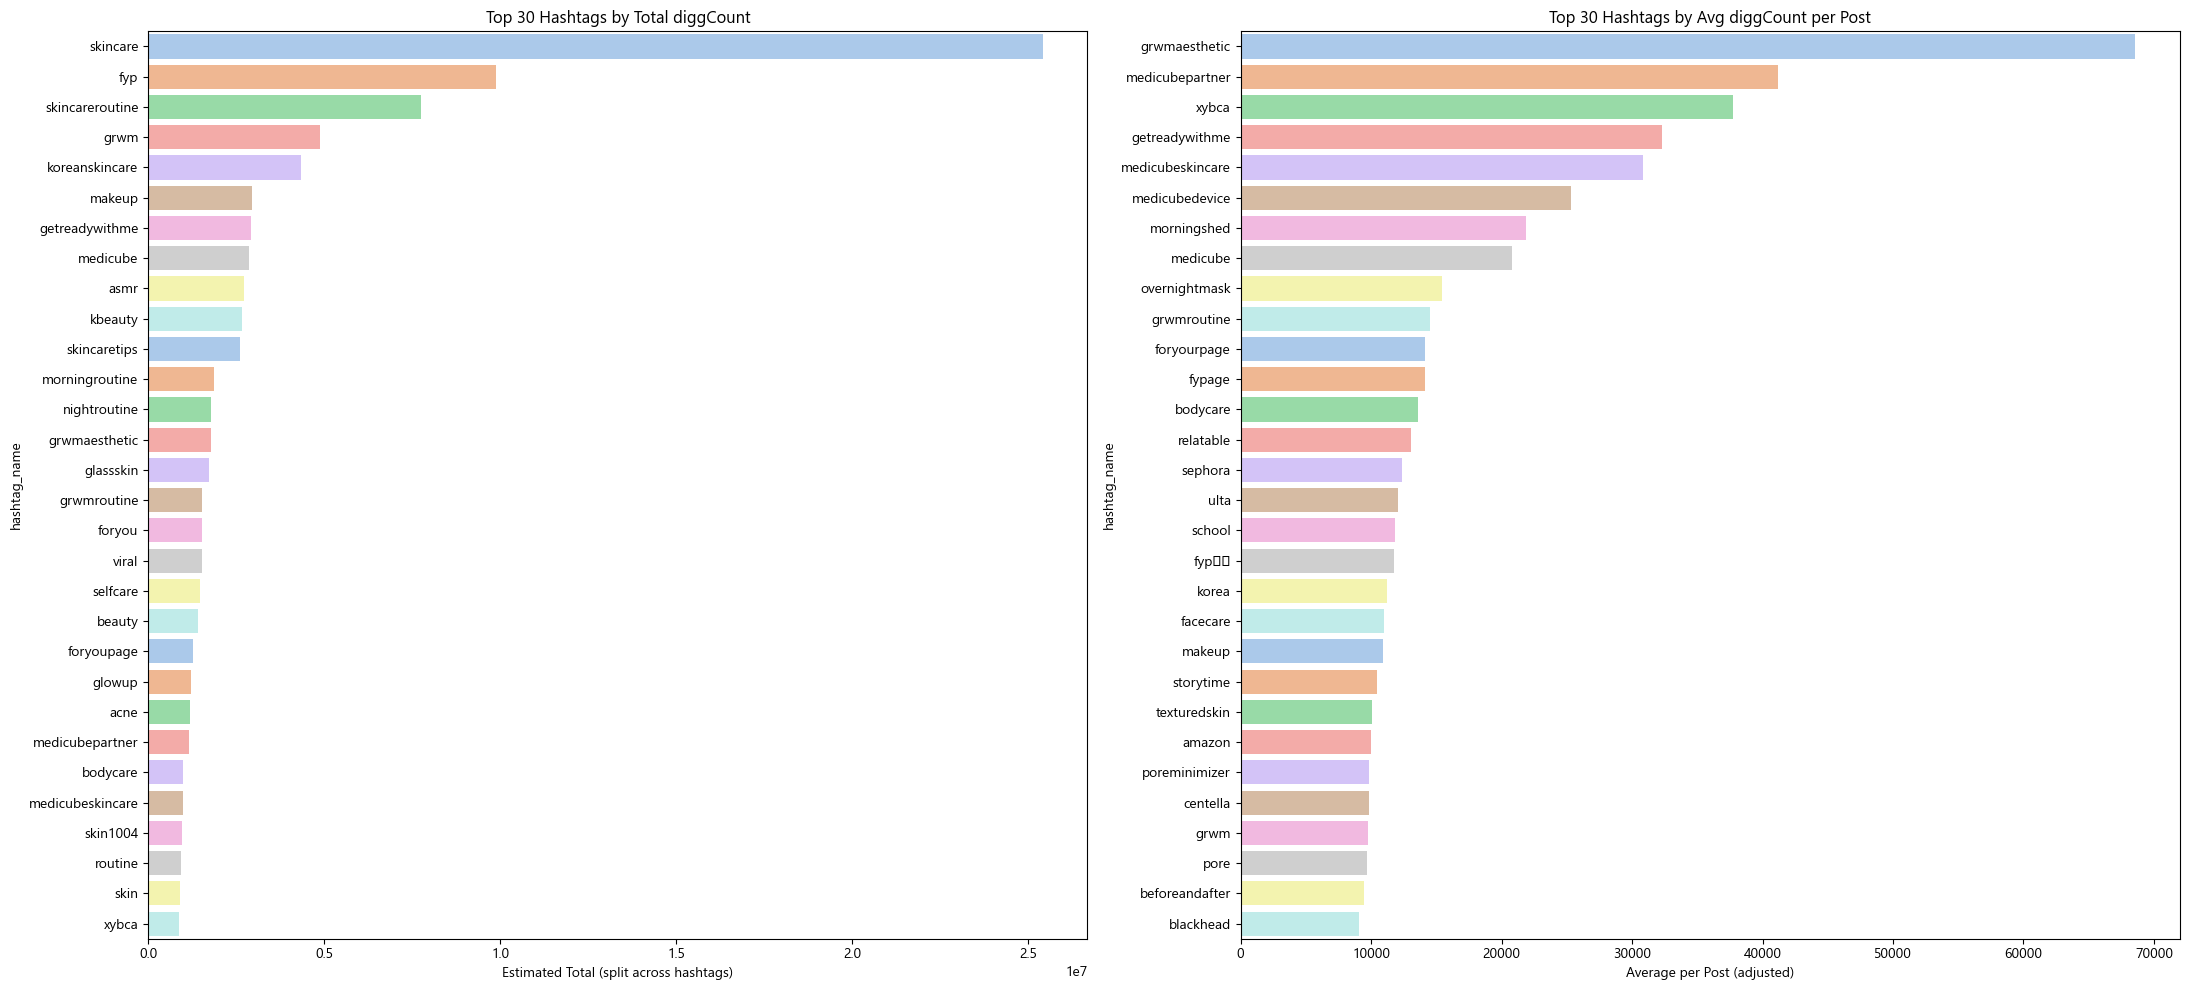

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


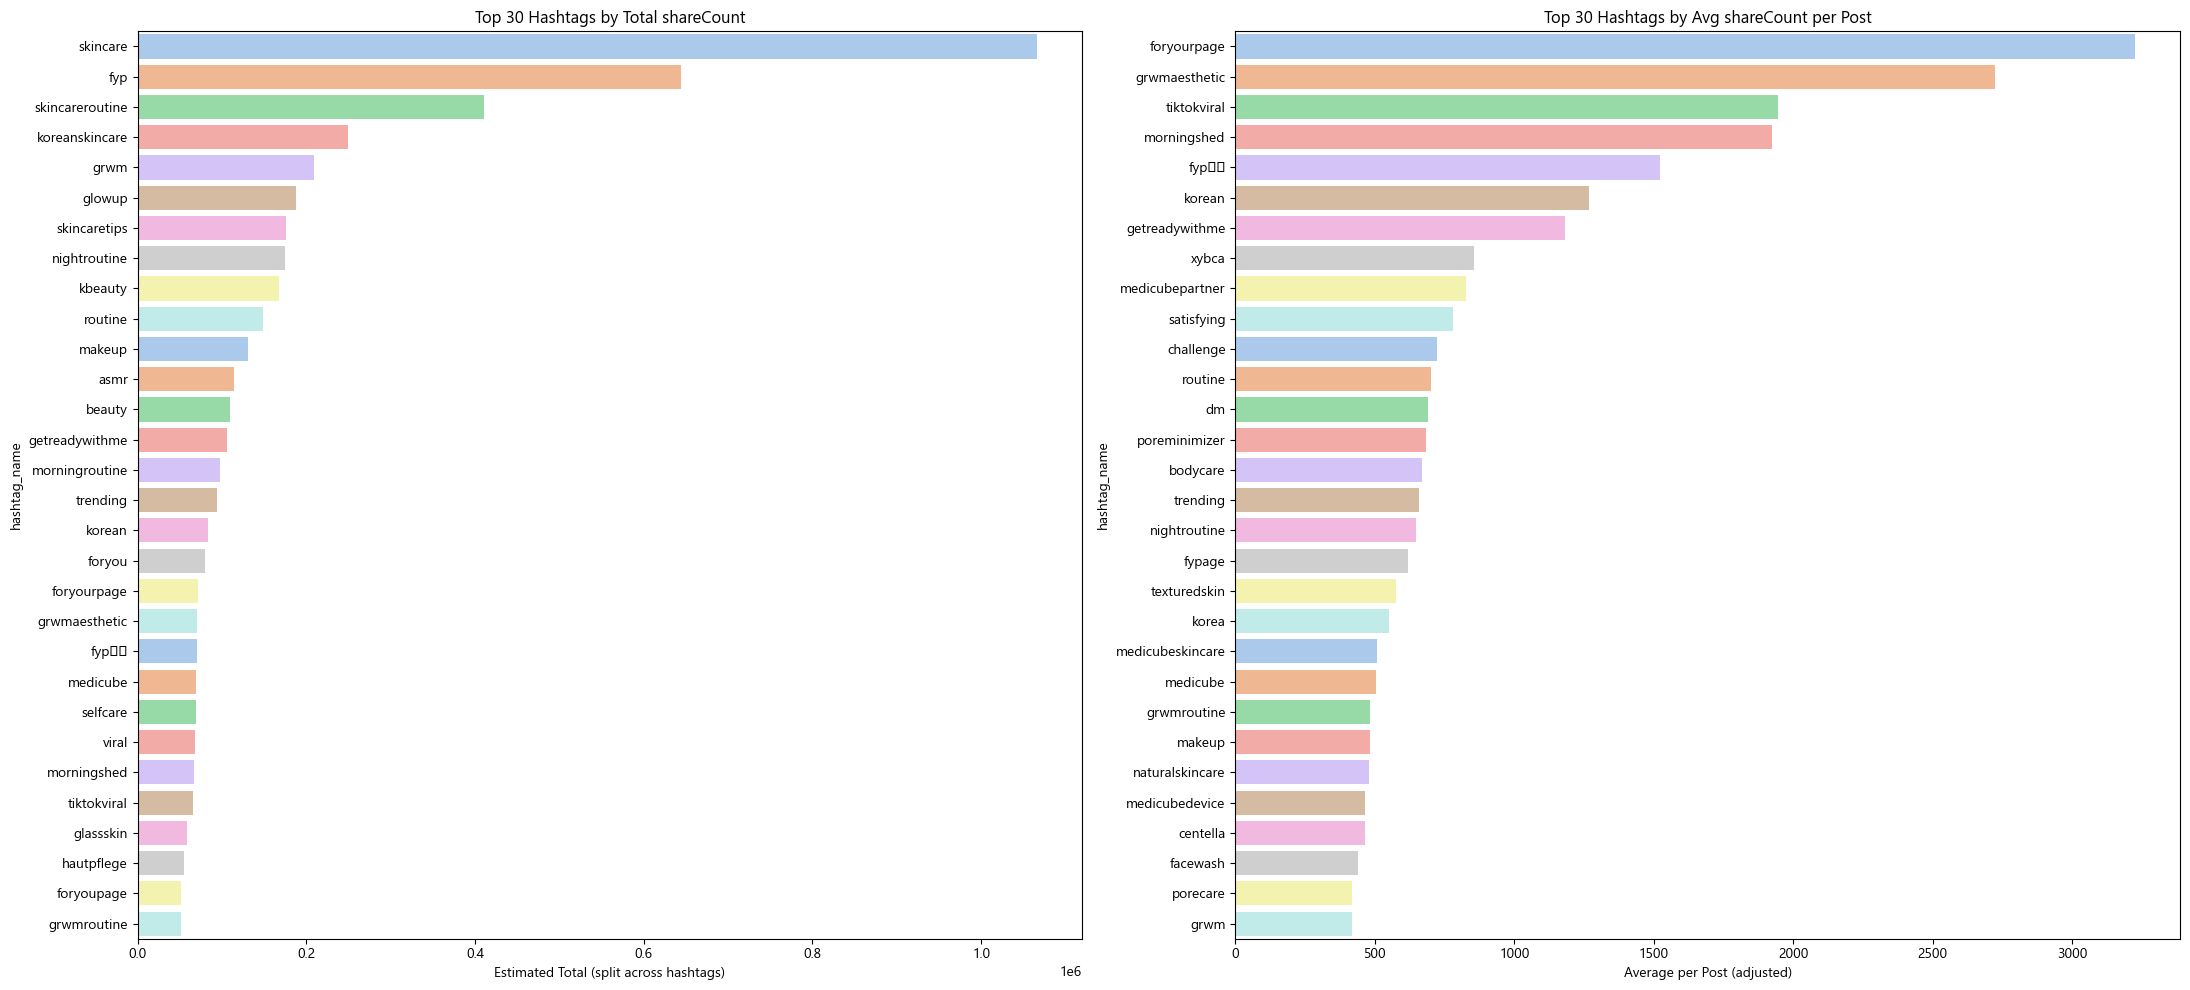

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\1681591976.py:62: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12442 (\N{COMBINING KATAKANA-HIRAGANA SEMI-VOICED SOUND MARK}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


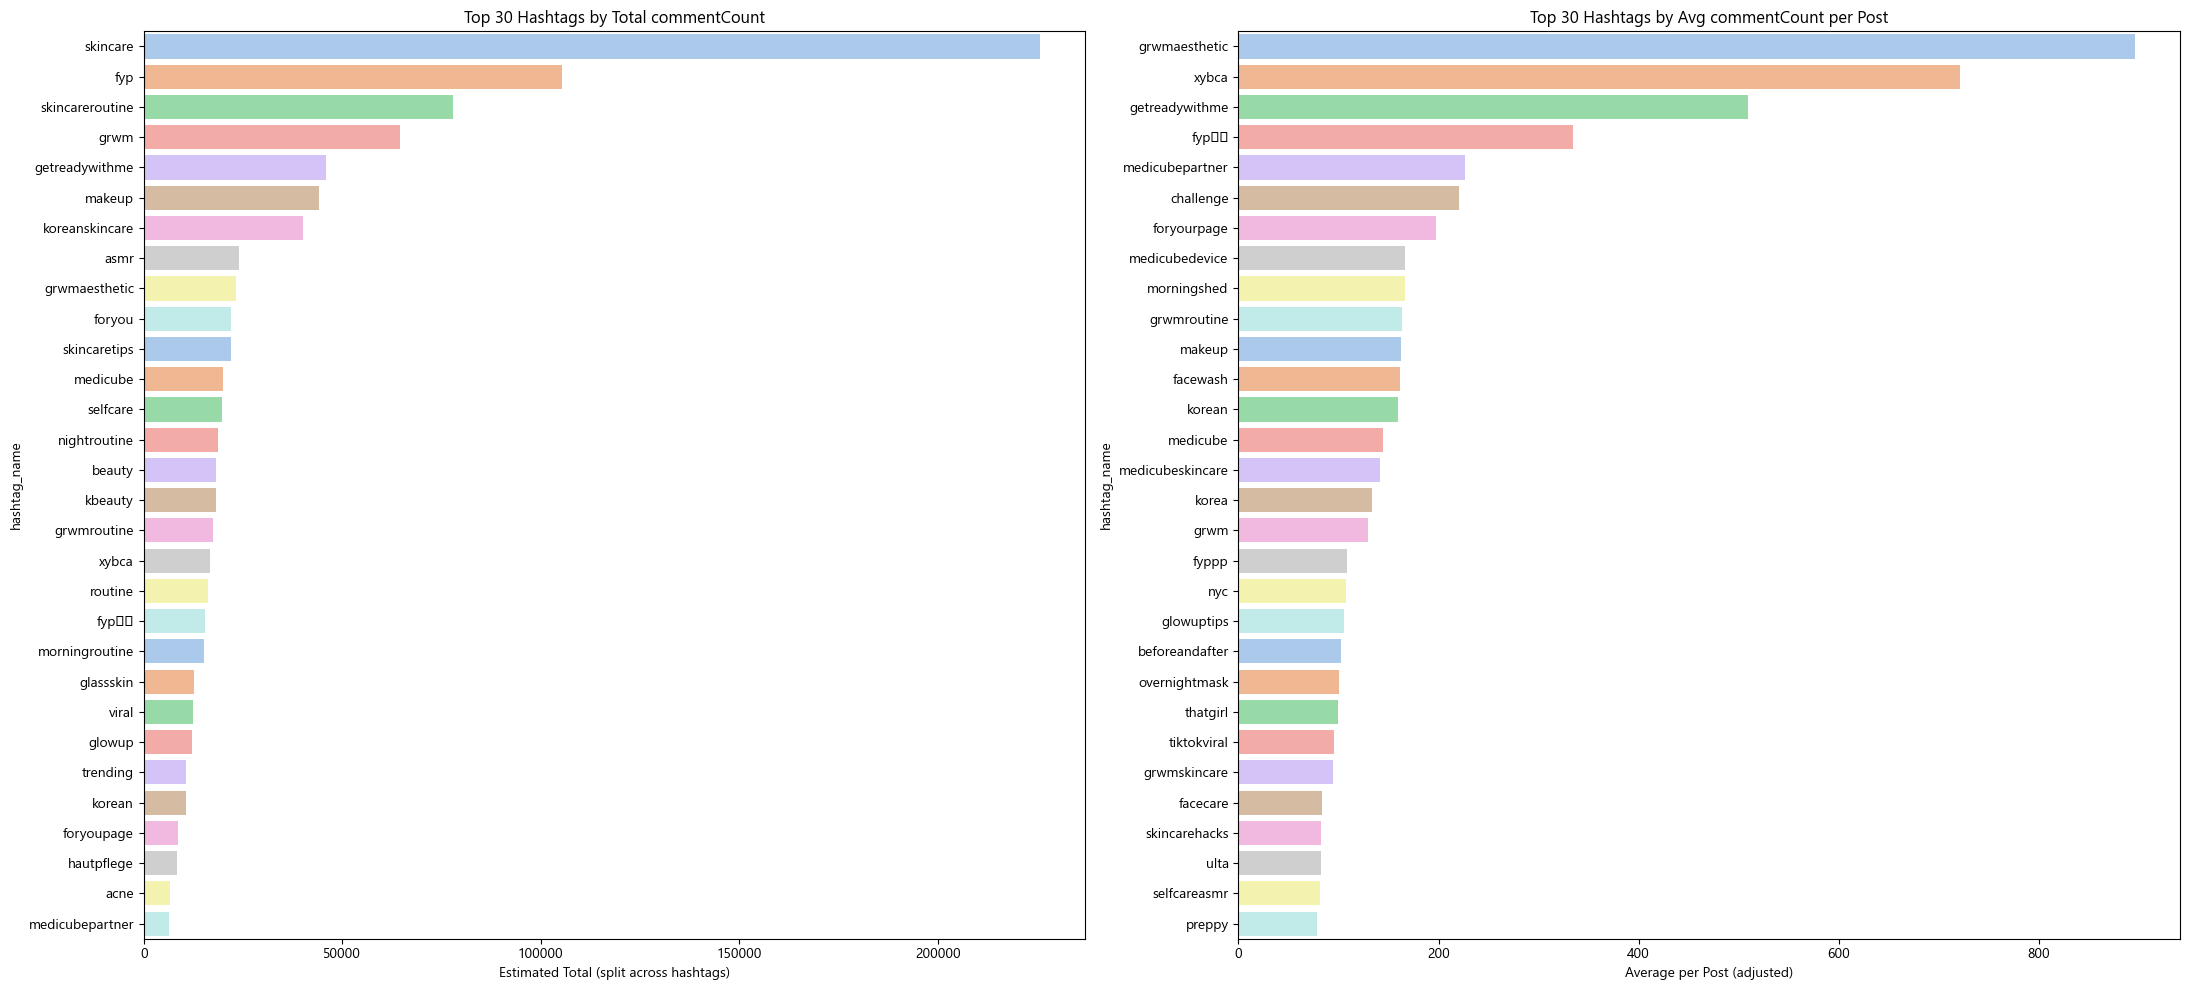

In [ ]:
# Total vs. average engagement for hashtags (by likes and views)

# Number of hashtags per post
data_hashtags['hashtag_count'] = data_hashtags.groupby('post_id')['hashtag_name'].transform('count')

# Distribute metric
for metric in ['playCount', 'diggCount', 'shareCount', 'commentCount']:
    data_hashtags[f'{metric}_per_hashtag'] = data_hashtags[metric] / data_hashtags['hashtag_count']

def plot_sum_and_avg_by_metric(data):
    metrics = ['playCount', 'diggCount', 'shareCount', 'commentCount']
    
    # Calculate fair share per hashtag
    data['hashtag_count'] = data.groupby('post_id')['hashtag_name'].transform('count')
    for metric in metrics:
        data[f'{metric}_per_hashtag'] = data[metric] / data['hashtag_count']
    
    for metric in metrics:
        metric_col = f'{metric}_per_hashtag'
        
        agg = (
            data.groupby('hashtag_name')
            .agg(
                post_count=('post_id', 'nunique'),
                total_metric=(metric_col, 'sum')
            )
            .assign(avg_metric_per_post=lambda x: x['total_metric'] / x['post_count'])
        )

        # Filter: only hashtags with at least 30 posts
        agg = agg[agg['post_count'] >= 20]

        # Top 30 by total and by average
        top_total = agg.sort_values('total_metric', ascending=False).head(30)
        top_avg = agg.sort_values('avg_metric_per_post', ascending=False).head(30)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))

        sns.barplot(
            x=top_total['total_metric'],
            y=top_total.index,
            hue=top_total.index,
            palette='pastel',
            legend=False,
            ax=axes[0]
        )
        axes[0].set_title(f"Top 30 Hashtags by Total {metric}")
        axes[0].set_xlabel("Estimated Total (split across hashtags)")

        sns.barplot(
            x=top_avg['avg_metric_per_post'],
            y=top_avg.index,
            hue=top_avg.index,
            palette='pastel',
            legend=False,
            ax=axes[1]
        )
        axes[1].set_title(f"Top 30 Hashtags by Avg {metric} per Post")
        axes[1].set_xlabel("Average per Post (adjusted)")

        plt.tight_layout()
        plt.show()


plot_sum_and_avg_by_metric(data_hashtags)

Across all four engagement metrics, views (playCount), likes (diggCount), shares (shareCount), and comments (commentCount), we observe a consistent pattern: broad, popular hashtags like #skincare, #fyp, and #grwm dominate in total engagement due to sheer volume of usage, but often underperform on a per-post basis. On the other hand, more niche or branded hashtags such as #grwmaesthetic, #medicubepartner, and #xybca consistently appear among the top performers when measured by average engagement per post. 

# Most Common Words (N-grams)

In [ ]:
# Combine English and German stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union(set(stopwords.words("german")))

# Basic text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  # Remove repeated words
    return text

# Tokenization while removing hashtags, usernames, links, and non-letter characters
def tokenize(text):
    if not isinstance(text, str):
        return []
    tokens = text.split()
    cleaned_tokens = []
    for w in tokens:
        if w.startswith('#') or w.startswith('@'):
            continue
        if 'http' in w or 'www.' in w:
            continue
        w = re.sub(r'[^a-zA-ZäöüÄÖÜß]', '', w)
        if w and w not in custom_stopwords and len(w) > 1:
            cleaned_tokens.append(w)
    return cleaned_tokens

# Function to compute top n-grams with relative frequency for the last 30 days
def compute_relative_ngrams(df, text_col, time_col, label):
    df = df.copy()
    df = df[df[time_col].notna()]
    df["clean_text"] = df[text_col].map(clean_text)
    df["tokens"] = df["clean_text"].map(tokenize)

    latest_date = df[time_col].max()
    start_date = latest_date - timedelta(days=30)
    df_30d = df[df[time_col] >= start_date]

    unigrams = [w for tokens in df_30d["tokens"] for w in tokens]
    bigrams = [" ".join(bg) for tokens in df_30d["tokens"] for bg in ngrams(tokens, 2)]
    trigrams = [
    " ".join(tg)
    for tokens in df_30d["tokens"]
    for tg in ngrams(tokens, 3)
    if len(set(tg)) > 1  # only include trigrams with at least 2 unique words
    ]

    # Helper to convert counts to relative frequency DataFrame
    def to_relative_df(counter, name):
        total = sum(dict(counter).values())
        df_ng = pd.DataFrame(counter, columns=[name, "Count"])
        df_ng[f"{name} %"] = (df_ng["Count"] / total) * 100
        return df_ng[[name, f"{name} %"]].round(2)

    top10_unigrams = Counter(unigrams).most_common(10)
    top10_bigrams = Counter(bigrams).most_common(10)
    top10_trigrams = Counter(trigrams).most_common(10)

    df_uni = to_relative_df(top10_unigrams, f"{label} Unigram")
    df_bi = to_relative_df(top10_bigrams, f"{label} Bigram")
    df_tri = to_relative_df(top10_trigrams, f"{label} Trigram")

    return pd.concat([df_uni, df_bi, df_tri], axis=1)

# Run the analysis for each text source
captions_df = compute_relative_ngrams(df_hashtags_posts_filtered, "text", "createTimeISO", "Captions")
comments_df = compute_relative_ngrams(df_comments_filtered, "comment", "createTimeISO", "Comments")
transcripts_df = compute_relative_ngrams(df_posts_transcripts_filtered, "transcribed_text", "createTimeISO", "Transcripts")

# Display results
from IPython.display import display
print("Captions — Top N-grams (Last 30 Days)")
display(captions_df)

print("Comments — Top N-grams (Last 30 Days)")
display(comments_df)

print("Transcripts — Top N-grams (Last 30 Days)")
display(transcripts_df)

Captions — Top N-grams (Last 30 Days)


,Captions Unigram,Captions Unigram %,Captions Bigram,Captions Bigram %,Captions Trigram,Captions Trigram %
0,haut,21.00,skincare routine,34.45,beauty personal care,14.13
1,skin,18.43,skin care,12.21,skin care routine,12.48
2,skincare,13.90,strahlende haut,9.64,morning skincare routine,10.99
3,routine,10.81,unbezahlte werbung,8.19,entdecke wahre schönheit,9.72
4,serum,8.60,zieht schnell,6.76,zieht schnell hinterlässt,9.57
5,glow,6.91,empfindliche haut,6.07,spendet intensiv feuchtigkeit,9.57
6,cream,5.77,link bio,5.99,thomas roth labs,9.34
7,products,4.96,morning skincare,5.61,letzter tag kauf,8.07
8,beauty,4.92,eye cream,5.55,tag kauf erhalte,8.07
9,cleanser,4.69,care routine,5.53,kauf erhalte gratisfeuchtigkeitsspendende,8.07


Comments — Top N-grams (Last 30 Days)


,Comments Unigram,Comments Unigram %,Comments Bigram,Comments Bigram %,Comments Trigram,Comments Trigram %
0,skin,24.20,skincare routine,16.45,jasper core photo,14.0
1,love,15.54,glass skin,13.82,acne prone skin,12.0
2,like,9.47,cleansing oil,9.87,lemon balm recipe,12.0
3,use,9.03,skin care,9.21,based cleanser moisturizer,10.0
4,face,7.92,looks like,9.21,need jasper core,10.0
5,ur,7.03,look like,9.21,skincare routine looks,10.0
6,just,6.96,oily skin,8.55,love ur vids,8.0
7,routine,6.88,skin type,7.89,skin care routine,8.0
8,products,6.66,youre pretty,7.89,whats skin type,8.0
9,good,6.29,love ur,7.89,nighttime skincare routine,8.0


Transcripts — Top N-grams (Last 30 Days)


,Transcripts Unigram,Transcripts Unigram %,Transcripts Bigram,Transcripts Bigram %,Transcripts Trigram,Transcripts Trigram %
0,like,20.40,skincare routine,17.48,skin care routine,19.87
1,skin,18.53,dont know,14.64,morning skincare routine,11.92
2,just,12.54,little bit,11.37,like dont know,10.60
3,going,8.69,feel like,11.28,qu en qu,10.60
4,know,6.94,skin care,10.08,en qu en,9.27
5,dont,6.87,just like,8.10,hyaluronic acid serum,7.95
6,haut,6.87,skin barrier,6.89,rebol ns rebol,7.95
7,really,6.42,eye cream,6.89,fine lines wrinkles,7.28
8,use,6.39,just going,6.80,just little bit,7.28
9,face,6.35,dark spots,6.46,acne prone skin,7.28


The tables show the relative frequency of the top 10 N-grams for comments, captions and in transcripts. Captions often contain promotional phrases, while comments reflect user reactions and emotions with terms like "love" and "you're pretty". Transcripts reveal informal, conversational language with "don't know", "feel like" and so on and some specifically skincare related topics (skin barrier, eye cream etc).

# Comments Analysis

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\318741063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_filtered['createTimeISO'] = pd.to_datetime(df_comments_filtered['createTimeISO'], errors='coerce')
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\318741063.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_filtered['comment_date'] = df_comments_filtered['createTimeISO'].dt.date


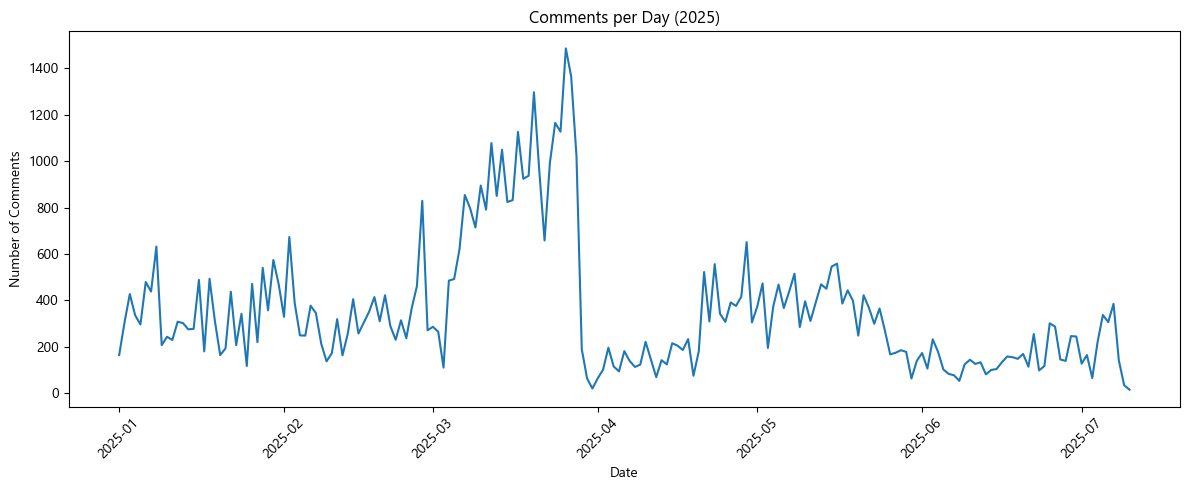

In [ ]:
# Convert the 'createTimeISO' column to datetime format (handle errors as NaT)
df_comments_filtered['createTimeISO'] = pd.to_datetime(df_comments_filtered['createTimeISO'], errors='coerce')

# Extract only the date part (year-month-day) from the datetime
df_comments_filtered['comment_date'] = df_comments_filtered['createTimeISO'].dt.date

# Filter comments from the year 2025 onwards
comments_2025 = df_comments_filtered[df_comments_filtered['comment_date'] >= pd.to_datetime("2025-01-01").date()]

# Count number of comments per day and sort by date
comments_per_day = comments_2025['comment_date'].value_counts().sort_index()

# Plot the number of comments per day in 2025
plt.figure(figsize=(12, 5))
comments_per_day.plot()
plt.title("Comments per Day (2025)")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There was a peak in the end of March and a massive fall down with the beginning in April. After talking to Peaks & Pies we figured that this was a technical issue coming from data limitation and not an actual fall down of comments.
Therefore it is important to normalize our statistics with the number of posts.

In [ ]:
# Compute comment lengths
df_comments_filtered['comment_length'] = df_comments_filtered['comment'].str.len()

# Calculate statistics
avg_comment_length = df_comments_filtered['comment_length'].mean()
median_comment_length = df_comments_filtered['comment_length'].median()

# Print results
print(f"Average comment length: {avg_comment_length:.2f} characters")
print(f"Median comment length: {median_comment_length:.0f} characters")

Average comment length: 42.14 characters
Median comment length: 31 characters


C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\2557200313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_filtered['comment_length'] = df_comments_filtered['comment'].str.len()


The median is noticeably lower than the average which suggests that the distribution is right skewed, meaning that while most comments are relatively short, a smaller number of much longer comments pull up the average. 
Possible reasons for this are Spam, links, or long promotional messages may be inflating the mean.

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\2470247337.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emojis), y=list(counts), palette="rocket")


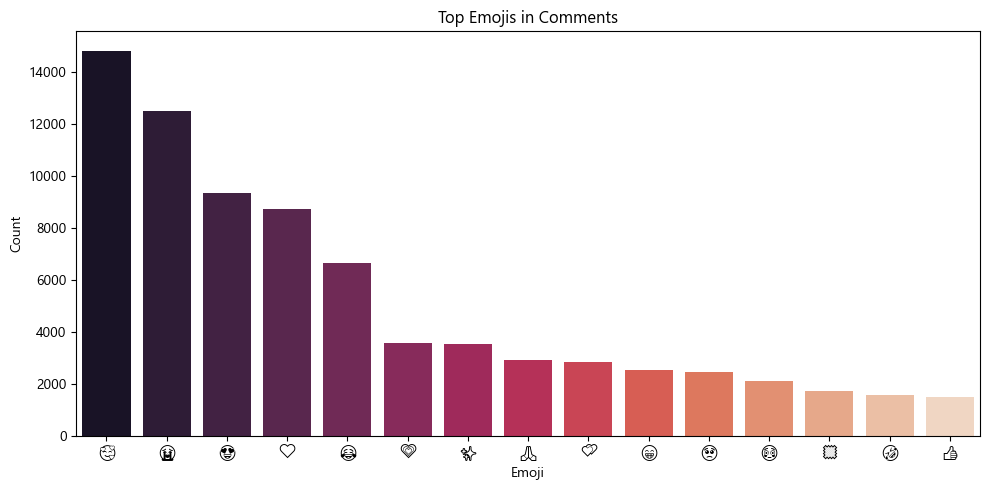

In [ ]:
# Most used emojis in comments and captions
# Set font globally
emoji_font = fm.FontProperties(fname="C:/Windows/Fonts/seguiemj.ttf")  # path to Segoe UI Emoji

plt.rcParams['font.family'] = emoji_font.get_name()


def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

def plot_most_common_emojis(df, column, title, top_n=15):
    all_emojis = []
    for text in df[column].dropna().astype(str):
        all_emojis.extend(extract_emojis(text))
    
    emoji_counts = Counter(all_emojis).most_common(top_n)
    emojis, counts = zip(*emoji_counts)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(emojis), y=list(counts), palette="rocket")
    plt.title(title)
    plt.xlabel("Emoji")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_most_common_emojis(df_comments_filtered, "comment", "Top Emojis in Comments")

The top emoji by a significant margin is 😂, followed by 😭 and 😍, suggesting that users often express strong emotional reactions such as humor, crying, and affection in their responses.

**Sentiment analysis for comments**

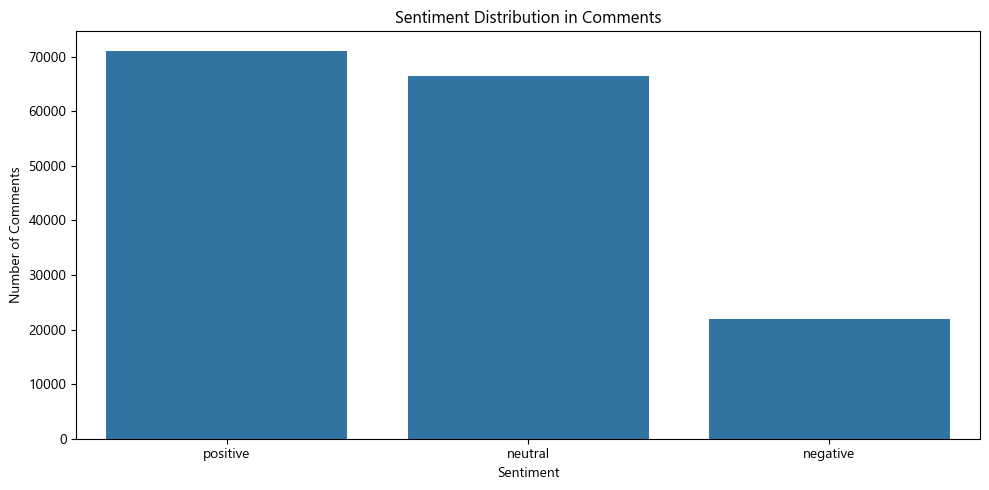

In [ ]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def analyze_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    compound = scores["compound"]
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply to comments
df_comments_clean = df_comments_filtered[df_comments_filtered["comment"].notna()].copy()
df_comments_clean["sentiment_label"] = df_comments_clean["comment"].apply(analyze_sentiment_vader)

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df_comments_clean, x="sentiment_label", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution in Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

Most skincare-related TikTok comments are classified as either positive or neutral, while negative sentiment is less frequent. Notably, a large portion of comments are labeled as neutral, which may include both genuinely neutral remarks and cases where the model is uncertain or the sentiment is ambiguous. Therefor we're taking a closer look at some example comments.

In [ ]:
# Sentiment function using VADER with confidence
def analyze_sentiment_vader_verbose(text):
    scores = analyzer.polarity_scores(text)
    compound = scores["compound"]
    if compound >= 0.05:
        sentiment = "positive"
    elif compound <= -0.05:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return pd.Series({
        "sentiment_label": sentiment,
        "sentiment_confidence": abs(compound)
    })

# Apply VADER sentiment to non-empty comments
df_comments_clean = df_comments_filtered[df_comments_filtered["comment"].notna()].copy()
df_comments_clean[["sentiment_label", "sentiment_confidence"]] = df_comments_clean["comment"].apply(analyze_sentiment_vader_verbose)

# Function to show top-N example comments per sentiment (no threshold)
def show_example_comments(df, sentiment, n=5):
    examples = df[df['sentiment_label'] == sentiment].copy()
    examples["confidence"] = examples["sentiment_confidence"].round(3)
    return examples[["sentiment_label", "comment", "confidence"]].sort_values(by="confidence", ascending=False).head(n)

# Display examples
for label in ["positive", "neutral", "negative"]:
    print(f"\n--- {label.upper()} EXAMPLES ---")
    display(show_example_comments(df_comments_clean, label))


--- POSITIVE EXAMPLES ---


,sentiment_label,comment,confidence
91502,positive,♥️♥️♥️😍😍😍😍😘😘🥰🥰🥰🤗🤗🤗❤️❤️❤️❤️💕💕💕💕❤️🥰🥰😘😍♥️♥️♥️♥️♥️...,1.0
207754,positive,😘😘😘😘😘😘♥️♥️♥️♥️😍😍😍😍😍🥰🥰🥰🥰🥰🥰💕💕💕💕💕❤️❤️❤️🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗...,1.0
68248,positive,nice🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️🥰🥰💋💋💋💋💋...,1.0
166822,positive,"Is that my glorious, elegant, intelligent, cha...",1.0
152032,positive,🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰,1.0



--- NEUTRAL EXAMPLES ---


,sentiment_label,comment,confidence
16992,neutral,That's so satisfying to watch😭,0.05
61399,neutral,Hello question please I have a seven years son...,0.05
112511,neutral,I really hope the people who complained actual...,0.05
73476,neutral,The mist does not protect you from UVA and UVB...,0.05
173892,neutral,you're so cute men😭🤩,0.05



--- NEGATIVE EXAMPLES ---


,sentiment_label,comment,confidence
12008,negative,Frrrrr 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭,0.997
135248,negative,I need that soooo bad 😢😢😢😢😢😢😢😭😭😭😭😭😭😫😫😫😫,0.995
194462,negative,I am a kid and said I am gonna ask my parents ...,0.994
125214,negative,its expensive 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭,0.994
133414,negative,They are so loud 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭,0.993


While the confidence for positive and negative comments are usually high, there is a big uncertainty about neutral comments. This highlights the importance of treating the neutral class with caution in further analysis. For model building, we may consider refining or reclassifying the neutral category either by incorporating confidence thresholds or using a more advanced sentiment model to ensure clearer sentiment separation and avoid diluting signal in downstream tasks.

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\4034549355.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\4034549355.py:20: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) Segoe UI Emoji.
  plt.tight_layout()
c:\Users\Surface\AppData\Local\pypoetry\Cache\virtualenvs\skincare-analysis-6rggZTBS-py3.10\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) Segoe UI Emoji.
  fig.canvas.print_figure(bytes_io, **kw)


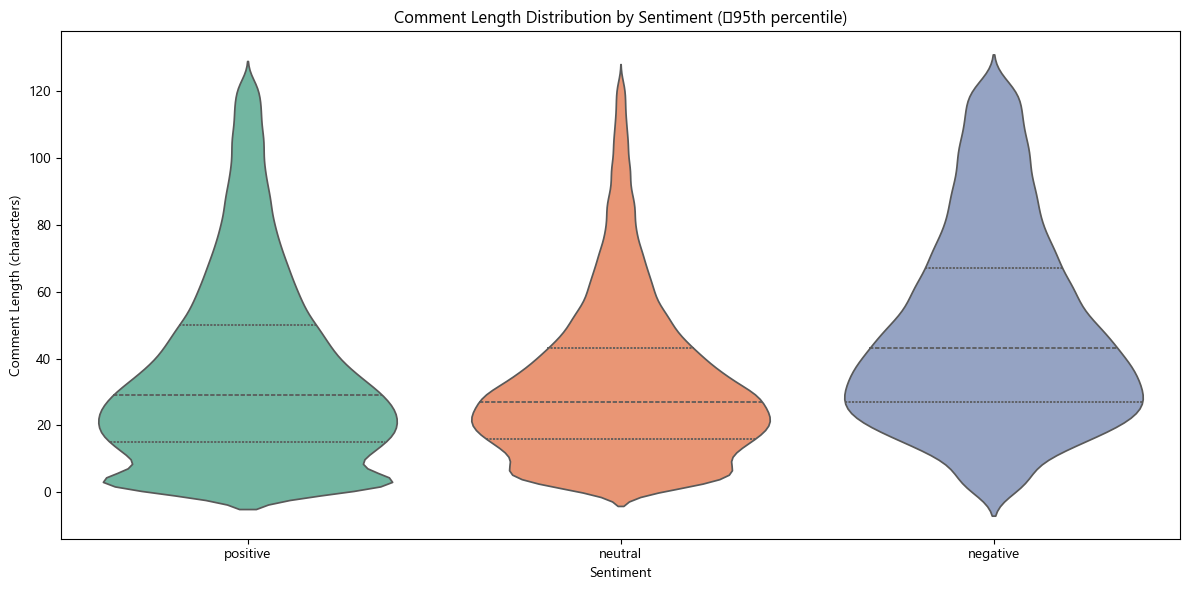

In [ ]:
# Create a new column for comment length
df_comments_clean["comment_length"] = df_comments_clean["comment"].str.len()

# Filter out extreme comment lengths (e.g. above 95th percentile)
max_length = df_comments_clean["comment_length"].quantile(0.95)
df_trimmed = df_comments_clean[df_comments_clean["comment_length"] <= max_length]

# Plot comment length by sentiment category
plt.figure(figsize=(12, 6))
sns.violinplot(
    x="sentiment_label", 
    y="comment_length", 
    data=df_trimmed, 
    palette="Set2", 
    inner="quartile"
)
plt.title("Comment Length Distribution by Sentiment (≤95th percentile)")
plt.xlabel("Sentiment")
plt.ylabel("Comment Length (characters)")
plt.tight_layout()
plt.show()


Positive and negative comments exhibit broader distributions and longer median lengths compared to neutral ones, suggesting that emotionally charged reactions - whether supportive or critical - often involve more elaborate expressions. In contrast, neutral comments are more concise and centered around shorter messages. This could indicate that neutral comments are more factual or less emotionally expressive. However, another interpretation is that the sentiment model has greater difficulty classifying very short comments, leading to a higher likelihood of assigning them a neutral label. To improve clarity for the plot we removed the top 5% outliers (some exceeding 10,000 characters) that could have skewed the interpretation.

# Ingredient Analysis

In [ ]:
# Define a mapping of synonyms (EN/DE) to unified ingredient names
ingredient_map = {
    "hyaluronic acid": ["hyaluronic acid", "hyaluronsäure"],
    "glycerin": ["glycerin"],
    "panthenol": ["panthenol"],
    "squalane": ["squalane", "squalan"],
    "aloe vera": ["aloe vera"],
    "niacinamide": ["niacinamide", "niacinamid"],
    "vitamin c": ["vitamin c"],
    "alpha arbutin": ["alpha arbutin", "alpha-arbutin"],
    "licorice root": ["licorice root", "lakritzextrakt"],
    "kojic acid": ["kojic acid", "kojicsäure"],
    "retinol": ["retinol"],
    "peptides": ["peptides", "peptide"],
    "bakuchiol": ["bakuchiol"],
    "coenzyme q10": ["coenzyme q10", "coenzym q10"],
    "ceramides": ["ceramides", "ceramide"],
    "salicylic acid": ["salicylic acid", "salicylsäure"],
    "glycolic acid": ["glycolic acid", "glycolsäure"],
    "lactic acid": ["lactic acid", "milchsäure"],
    "pha": ["pha"],
    "benzoyl peroxide": ["benzoyl peroxide", "benzoylperoxid"],
    "centella asiatica": ["centella asiatica", "tigergras"],
    "green tea": ["green tea", "grüner tee"],
    "allantoin": ["allantoin"],
    "calendula": ["calendula", "ringelblume"],
    "chamomile": ["chamomile", "kamille"]
}

C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\3651980391.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_comments["clean_text_comment"] = recent_comments["comment"].astype(str).str.lower()
C:\Users\Surface\AppData\Local\Temp\ipykernel_9768\3651980391.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_comments["matched_ingredients"] = recent_comments["clean_text_comment"].apply(match_ingredients)


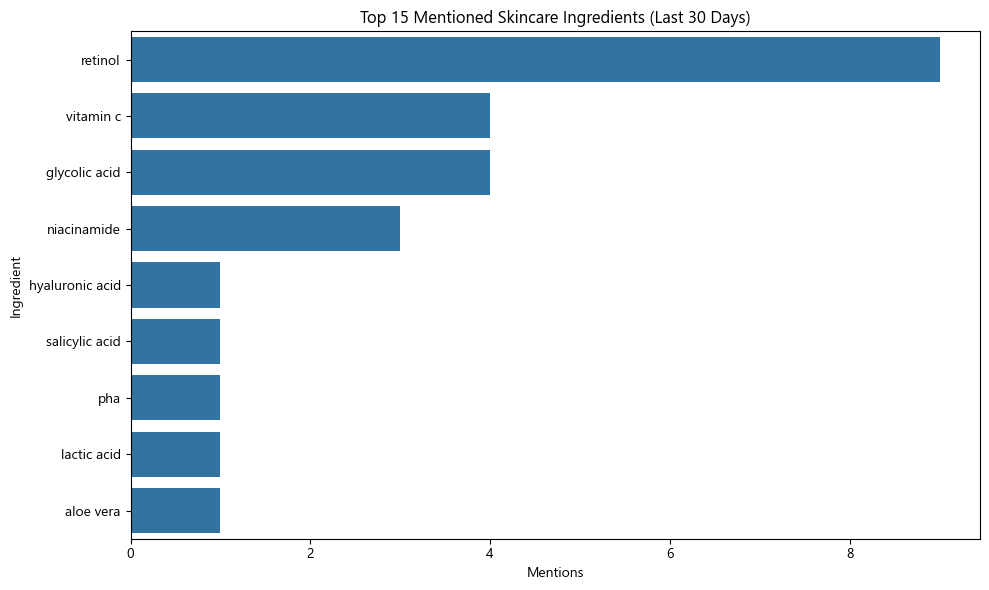

In [ ]:
# Define a reverse mapping: term -> unified ingredient name
synonym_to_ingredient = {
    synonym: key for key, synonyms in ingredient_map.items() for synonym in synonyms
}

# Add date column
df_comments_clean["createTimeISO"] = pd.to_datetime(df_comments_clean["createTimeISO"], errors="coerce")
df_comments_clean["date"] = df_comments_clean["createTimeISO"].dt.date

# Filter comments from the last 30 days
cutoff_date = df_comments_clean["date"].max() - pd.Timedelta(days=30)
recent_comments = df_comments_clean[df_comments_clean["date"] >= cutoff_date]

# Create a cleaned, lowercased comment column for matching
recent_comments["clean_text_comment"] = recent_comments["comment"].astype(str).str.lower()

# Match ingredients in cleaned text
def match_ingredients(text):
    if pd.isna(text):
        return []
    matched = []
    for synonym, ingredient in synonym_to_ingredient.items():
        if synonym in text:
            matched.append(ingredient)
    return list(set(matched))  # Avoid duplicates per comment

recent_comments["matched_ingredients"] = recent_comments["clean_text_comment"].apply(match_ingredients)

# Explode and count
exploded = recent_comments.explode("matched_ingredients")
ingredient_counts = exploded["matched_ingredients"].value_counts().head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ingredient_counts.values, y=ingredient_counts.index)
plt.title("Top 15 Mentioned Skincare Ingredients (Last 30 Days)")
plt.xlabel("Mentions")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

Over the past 30 days retinol was by far the ingredient that was mentioned the most although the abosulte numbers are generally not that high compared to the size of the dataset.

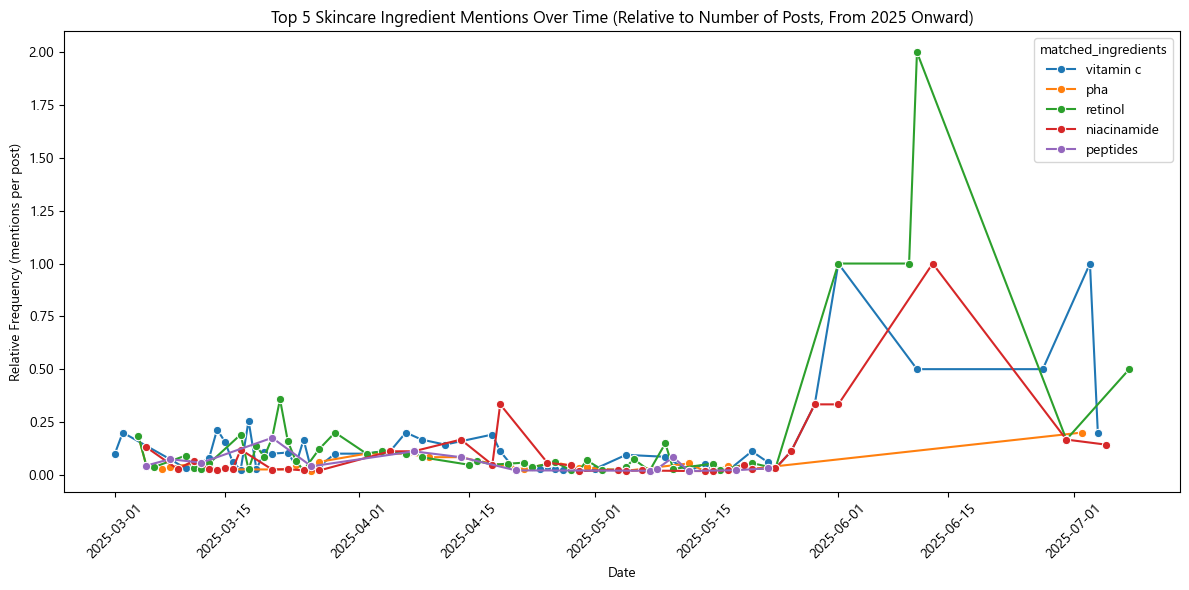

In [ ]:
# Use all comments from 2025 onward
comments_2025 = df_comments_clean[df_comments_clean["date"] >= pd.to_datetime("2025-03-01").date()].copy()

# Clean and lowercase comment text
comments_2025["clean_text_comment"] = comments_2025["comment"].astype(str).str.lower()

# Match ingredients
comments_2025["matched_ingredients"] = comments_2025["clean_text_comment"].apply(match_ingredients)

# Explode to one row per ingredient
exploded_2025 = comments_2025.explode("matched_ingredients")

# Get top 5 ingredients overall from 2025
ingredient_counts_2025 = exploded_2025["matched_ingredients"].value_counts().head(5)
top_5_ingredients = ingredient_counts_2025.index.tolist()

# Filter to only those top 5 ingredients
filtered = exploded_2025[exploded_2025["matched_ingredients"].isin(top_5_ingredients)]

# Count ingredient mentions per day
ingredient_daily = (
    filtered.groupby(["date", "matched_ingredients"])
    .size()
    .reset_index(name="ingredient_count")
)

# Count number of unique posts per day
daily_post_counts = (
    comments_2025.groupby("date")["post_id"]
    .nunique()
    .reset_index(name="total_posts")
)

# Merge and calculate relative frequency per post
ingredient_daily = ingredient_daily.merge(daily_post_counts, on="date")
ingredient_daily["relative_freq"] = ingredient_daily["ingredient_count"] / ingredient_daily["total_posts"]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=ingredient_daily,
    x="date",
    y="relative_freq",
    hue="matched_ingredients",
    marker="o"
)
plt.title("Top 5 Skincare Ingredient Mentions Over Time (Relative to Number of Posts, From 2025 Onward)")
plt.xlabel("Date")
plt.ylabel("Relative Frequency (mentions per post)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Retinol had a spike around mid-June. Niacinamide and vitamin C also saw noticeable upticks around early to mid-June, suggesting either a viral trend or coordinated discussion.

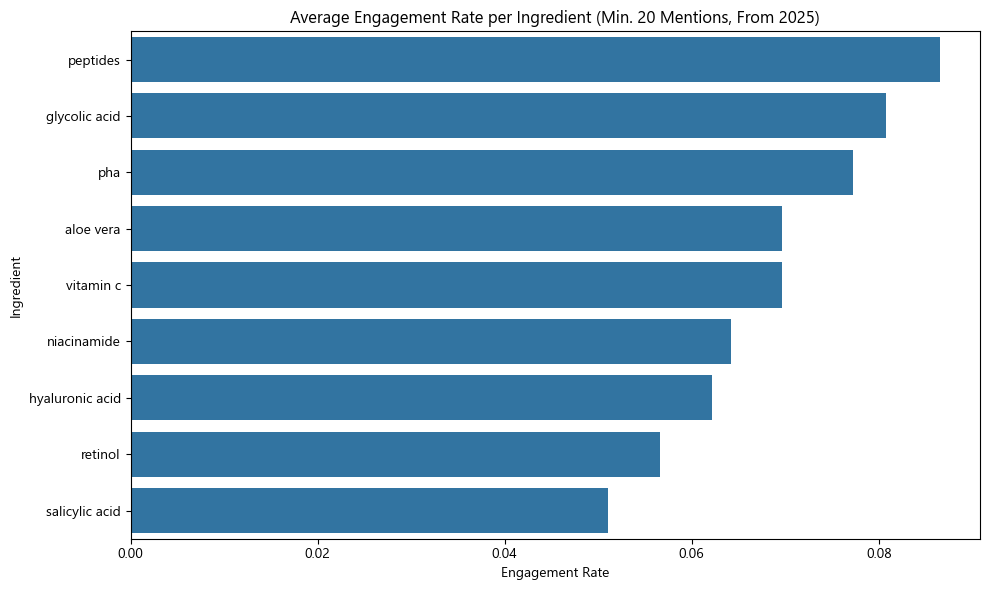

In [ ]:
# Filter to comments with at least one matched ingredient
df_filtered = comments_2025[comments_2025["matched_ingredients"].str.len() > 0].copy()

# Calculate engagement rate per post
df_filtered["engagement_rate"] = (
    df_filtered["diggCount"] + df_filtered["commentCount"] + df_filtered["shareCount"]
) / df_filtered["playCount"]

# Explode ingredients
df_exploded = df_filtered.explode("matched_ingredients")

# Filter to ingredients with at least 20 mentions
ingredient_counts = df_exploded["matched_ingredients"].value_counts()
valid_ingredients = ingredient_counts[ingredient_counts >= 20].index
df_exploded_filtered = df_exploded[df_exploded["matched_ingredients"].isin(valid_ingredients)]

# Compute average engagement rate per ingredient
ingredient_stats = (
    df_exploded_filtered.groupby("matched_ingredients")["engagement_rate"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=ingredient_stats, x="engagement_rate", y="matched_ingredients")
plt.title("Average Engagement Rate per Ingredient (Min. 20 Mentions, From 2025)")
plt.xlabel("Engagement Rate")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

# Music

In [ ]:
# Top music tracks and authors
# convert to datetime
df_music['createTimeISO'] = pd.to_datetime(df_music['createTimeISO'])

# Filter to last 30 days
latest_date = df_music['createTimeISO'].max()
start_date = latest_date - timedelta(days=30)
df_music_30d = df_music[df_music['createTimeISO'] >= start_date]

# Drop missing values
df_music_30d = df_music_30d.dropna(subset=['musicName', 'musicAuthor'])

# Top music tracks
top_tracks = Counter(df_music_30d['musicName']).most_common(10)
total_tracks = len(df_music_30d)
df_tracks = pd.DataFrame(top_tracks, columns=['Track', 'Count'])
df_tracks['% of Posts'] = (df_tracks['Count'] / total_tracks * 100).round(2)

# Top music authors
top_authors = Counter(df_music_30d['musicAuthor']).most_common(10)
df_authors = pd.DataFrame(top_authors, columns=['Author', 'Count'])
df_authors['% of Posts'] = (df_authors['Count'] / total_tracks * 100).round(2)

# Display
print(f"Top 10 Music Tracks (Last 30 Days since {start_date.date()}):")
display(df_tracks)

print(f"\nTop 10 Music Authors (Last 30 Days since {start_date.date()}):")
display(df_authors)

Top 10 Music Tracks (Last 30 Days since 2025-06-10):


,Track,Count,% of Posts
0,Originalton,2866,31.57
1,original sound,2510,27.65
2,son original,209,2.30
3,GRR,140,1.54
4,sonido original,122,1.34
5,Originalton - shiaknowsbest,111,1.22
6,الصوت الأصلي,94,1.04
7,оригинальный звук,91,1.00
8,sunet original,56,0.62
9,som original,54,0.59



Top 10 Music Authors (Last 30 Days since 2025-06-10):


,Author,Count,% of Posts
0,Fantomel,193,2.13
1,✨AnnaBeautyMaus✨,192,2.11
2,Maxim Giacomo,137,1.51
3,ClaudeBeauty,123,1.35
4,shiaknowsbest,111,1.22
5,Tom Hannemann,104,1.15
6,nona,95,1.05
7,Bennet,89,0.98
8,Alenamari ☀️,83,0.91
9,Laura Spiessmacher | Haircare,76,0.84


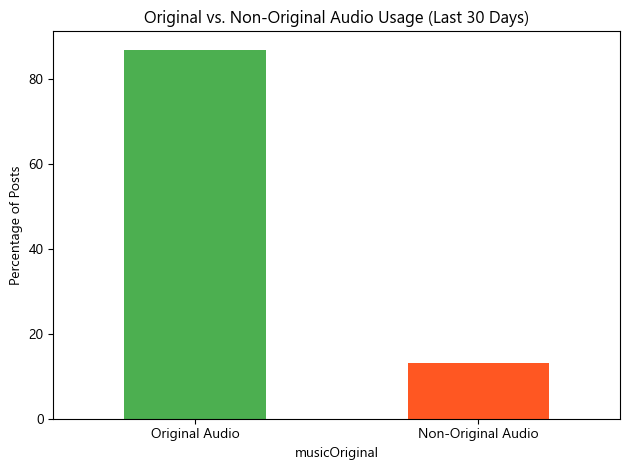

In [ ]:
# Count original vs. non-original audio
audio_counts = df_music_30d['musicOriginal'].value_counts(normalize=True) * 100
audio_counts = audio_counts.rename({True: 'Original Audio', False: 'Non-Original Audio'}).round(2)

# Bar plot
audio_counts.plot(kind='bar', color=['#4CAF50', '#FF5722'])
plt.title("Original vs. Non-Original Audio Usage (Last 30 Days)")
plt.ylabel("Percentage of Posts")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Most of the top music tracks used are original audio which indicates a highly diverse and creator-driven sound landscape. Additionally, no single music author dominates the dataset, the most used author accounts for just 2.13% of posts. This suggests that audio usage is fragmented, and viral sounds are less tied to specific artists, making it difficult to analyze music related trends.